In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from scipy import optimize
from autograd import grad

In [40]:
## Neuron parameters
tau = 10.
eta_0 = 0.1
tau_adapt = 10.
v = 0
delta_u = 1.
mu_M = 1e-3
mu_Q = 1e-5
tau_G = 10.
tau_baseline = 100.
dt = 1.
stair_firing_rate = 0.7
nonstair_firing_rate = 0.001

In [41]:
def get_phi_or_eta_update(data, phi_or_eta, curr_time, timescale, time_constant):
    
    return timescale * (1 / time_constant) * (data[:, curr_time - 1] - phi_or_eta[:, curr_time - 1])

def update_phi_or_eta(phi_or_eta, curr_time, update_val):
    
    return phi_or_eta[:, curr_time - 1] + update_val

def update_potential(u_, weight_matrix, phi_, eta_, curr_time):
    
    return np.matmul(weight_matrix, phi_[:, curr_time]) - eta_0 * eta_[:, curr_time]

def get_spike_probs(u_, curr_time):

    # bernoulli spike probability
    return sigmoid(u_[:, curr_time])

def draw_spikes(spike_probs_, curr_time):
    
    # draw bernoulli spikes
    return np.random.binomial(n = 1, p = spike_probs_[:, curr_time])

def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

In [42]:
## NETWORK PARAMTERS
num_visible = 9
num_hidden = 15
num_neurons = num_visible + num_hidden
num_timebins = 1000

In [43]:
## INITIALIZE WEIGHTS
weights_M = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(weights_M[:num_visible, :num_visible], 0) # no self-connections for visible neurons

weights_Q = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))

# no connections from visible->visible or hidden->visible in Q weights (top half of matrix)
weights_Q[:num_visible, :] = 0

In [44]:
# INITIALIZE NETWORK RUN
phi = np.zeros(shape = (num_neurons, num_timebins))
eta = np.zeros(shape = (num_neurons, num_timebins))
u = np.zeros(shape = (num_neurons, num_timebins))
spikes = np.zeros(shape = (num_neurons, num_timebins))
spike_probs = np.zeros(shape = (num_neurons, num_timebins))

# phi[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
phi[:, 0] = np.zeros(num_neurons)
# eta[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
eta[:, 0] = np.zeros(num_neurons)
u[:, 0] = np.matmul(weights_M, phi[:, 0]) - eta[:, 0]
# spike_probs[:, 0] = sigmoid(u[:, 0])
spike_probs[:, 0] = get_spike_probs(u, 0)
spikes[:, 0] = np.random.binomial(n = 1, p = spike_probs[:, 0])

In [45]:
## GENERATE STAIRCASE PATTERN

def get_staircase(num_timebins, num_neurons_, num_visible_, weight_matrix, stair_fr=0.7, nonstair_fr=0.001, num_blocks=3):
    
    timebin_padding = 20
    num_timebins_padded = num_timebins + timebin_padding
    
    # INITIALIZE NETWORK RUN
    phi = np.zeros(shape = (num_neurons_, num_timebins_padded))
    eta = np.zeros(shape = (num_neurons_, num_timebins_padded))
    u = np.zeros(shape = (num_neurons_, num_timebins_padded))
    spikes = np.zeros(shape = (num_neurons_, num_timebins_padded))
    spike_probs = np.zeros(shape = (num_neurons_, num_timebins_padded))

    phi[:, 0] = np.zeros(num_neurons_)
    eta[:, 0] = np.zeros(num_neurons_)
    u[:, 0] = np.matmul(weight_matrix, phi[:, 0]) - eta[:, 0]
    spike_probs[:, 0] = get_spike_probs(u, 0)
    spikes[:, 0] = np.random.binomial(n = 1, p = spike_probs[:, 0])

    neuron_block_size = np.floor(num_visible_ * 1.0 / num_blocks)
    curr_neuron_block = np.random.choice(np.arange(num_blocks))
    interval_idx = 0
    timebin_counter = 0

    # intervals for length of "stairs"
    gaussian_intervals = np.random.normal(size = 10000, loc=30, scale=10).astype(int)
    gaussian_intervals[gaussian_intervals <= 3] = 3

    spikes[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1

    # simulate network
    for tt in range(1, num_timebins_padded):

        # changes in potential
        dphi = get_phi_or_eta_update(data=spikes, phi_or_eta=phi, curr_time=tt, time_constant=tau, timescale=dt)
        deta = get_phi_or_eta_update(data=spikes, phi_or_eta=eta, curr_time=tt, time_constant=tau_adapt, timescale=dt)
        
        phi[:, tt] = update_phi_or_eta(phi_or_eta=phi, update_val=dphi, curr_time=tt)
        eta[:, tt] = update_phi_or_eta(phi_or_eta=eta, update_val=deta, curr_time=tt)

#         phi[:, tt] = phi[:, tt - 1] + dphi
#         eta[:, tt] = eta[:, tt - 1] + deta

        u[:, tt] = update_potential(u, weight_matrix, phi, eta, tt)

#         total_potential = np.matmul(weight_matrix, phi[:, tt]) - eta_0 * eta[:, tt]
#         u[:, tt] = total_potential

        spike_probs[:, tt] = get_spike_probs(u, tt)

#         spike_probs[:, tt] = 1 / (1 + np.exp(-u[:, tt]))
    
        # stair firing rates are fixed
        nonblock_idx = np.delete(np.arange(num_visible), np.arange(int(curr_neuron_block * neuron_block_size), int((curr_neuron_block + 1) * neuron_block_size)))
        spike_probs[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] = stair_fr
        spike_probs[nonblock_idx, tt] = nonstair_fr
        
        spikes[:, tt] = draw_spikes(spike_probs, tt)
    
        # draw bernoulli spikes
#         spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])

        # which neurons are the new stairs?
        timebin_counter += 1
        if timebin_counter == gaussian_intervals[interval_idx]:
            interval_idx += 1
            timebin_counter = 0
            if curr_neuron_block < 2:
                curr_neuron_block += 1
            else:
                curr_neuron_block = 0
                
    return spikes[:, timebin_padding:], phi[:, timebin_padding:], eta[:, timebin_padding:], u[:, timebin_padding:], spike_probs[:, timebin_padding:]

In [46]:
spikes, phi, eta, u, spike_probs = get_staircase(num_timebins=1000, 
                                                      num_neurons_=num_neurons, 
                                                      num_visible_=num_visible, 
                                                      weight_matrix=weights_M,
                                                      stair_fr=stair_firing_rate, 
                                                      nonstair_fr=nonstair_firing_rate)

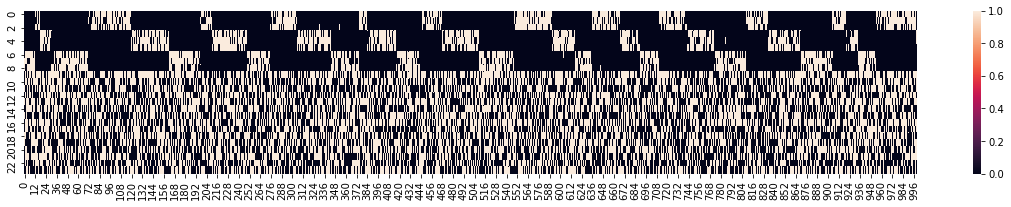

In [47]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes)

In [48]:
# total_potential = np.matmul(learned_weights_Q, phi_Q) - eta_0 * eta_Q

# p_pred = sigmoid(total_potential)

# individual_likelihoods = bernoulli_likelihood(spikes_Q, p_pred, dt)
# sns.heatmap(individual_likelihoods[:, :600])


# # print np.sum(np.isnan(p_pred))
# # print np.max(p_pred)
# # print LL_Q(learned_weights_Q)

# individual_likelihoods = np.multiply(spikes_Q, np.log(p_pred)) * dt + np.multiply((1 - spikes_Q), np.log(1 - p_pred)) * dt
# # print np.sum(np.log(p_pred))

# print np.min(np.log(p_pred)), np.max(np.log(p_pred))

In [49]:
## FUNCTIONS FOR M AND Q LIKELIHOODS AND THEIR GRADIENTS

import autograd.numpy as np

def bernoulli_likelihood(data, p_pred, timescale):
    p_pred[np.where(p_pred == 1)] = 1 - 1e-5
    p_pred[np.where(p_pred == 0)] = 1e-5
    individual_likelihoods = np.multiply(data, np.log(p_pred)) * timescale + np.multiply((1 - data), np.log(1 - p_pred)) * timescale
    return individual_likelihoods

## Likelihood of M network
def LL_M(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi) - eta_0 * eta
#     total_potential[num_visible:, :] = u_Q[num_visible:, :].copy()
    
    p_pred = sigmoid(total_potential)
    
    individual_likelihoods = bernoulli_likelihood(spikes, p_pred, dt)
    LL = np.sum(individual_likelihoods)
    return LL

## Likelihood of Q network
def LL_Q(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi_Q) - eta_0 * eta_Q

    p_pred = sigmoid(total_potential)

    individual_likelihoods = bernoulli_likelihood(spikes_Q, p_pred, dt)
    LL = np.sum(individual_likelihoods[num_visible:, 1:]) # (only sums over hidden neurons)
    return LL

def LL_M_gradient_by_hand(curr_weights, curr_phi, curr_eta, curr_spikes):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])
    
    total_potential = np.matmul(curr_weights, curr_phi) - eta_0 * curr_eta
#     total_potential[num_visible:, :] = u_Q[num_visible:, :].copy()
    
    p_pred = sigmoid(total_potential)
    
    curr_grad = np.matmul(curr_spikes - p_pred, curr_phi.T)
    return curr_grad

def LL_Q_gradient_by_hand(curr_weights, curr_phi, curr_eta, curr_spikes):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])
    
    total_potential = np.matmul(curr_weights, curr_phi) - eta_0 * curr_eta
#     total_potential[num_visible:, :] = u_Q[num_visible:, :].copy()
    
    p_pred = sigmoid(total_potential)
    
    curr_grad = np.matmul(curr_spikes - p_pred, curr_phi.T)
    curr_grad[:num_visible, :] = 0
    return curr_grad



In [50]:
# print grad_LL_M(learned_weights_M)[0, :]
# print LL_M_gradient_by_hand(learned_weights_M)[0, :]

In [51]:
# GRADIENTS COURTESY OF AUTOGRAD
grad_LL_M = grad(LL_M)
grad_LL_Q = grad(LL_Q)

In [52]:
# INITIALIZE WEIGHTS FOR LEARNING
learned_weights_M = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(learned_weights_M, 0)

learned_weights_Q = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(learned_weights_Q, 0)

# VALUES TO STORE OVER TRAINING
free_energy_trace = []
mean_subtract_free_energy_trace = []
LL_M_trace = []
LL_Q_trace = []

In [53]:
def heatmap_weights(weights_m, weights_q):
    f = plt.figure(figsize=(10, 3))
    f.add_subplot(121)
    plt.title("M weights")
    sns.heatmap(weights_m)
    f.add_subplot(122)
    sns.heatmap(weights_q)
    plt.title("Q weights")
    plt.show()

In [54]:
def simulate_q_network(num_timebins_):

    ## Simulate Q network to get expected likelihood under the current Q weights
    phi_Q = phi.copy()
    eta_Q = eta.copy()
    u_Q = u.copy()
    spikes_Q = np.zeros(shape=(num_neurons, num_timebins_))
    spike_probs_Q = spike_probs.copy() #np.zeros(shape=(num_neurons, num_timebins))
    spike_probs_Q[:, 0] = get_spike_probs(u_Q, 0)
    spikes_Q[:, 0] = 0 #np.random.binomial(n = 1, p = spike_probs_Q[:, 0])
    spikes_Q[:num_visible, :] = spikes[:num_visible, :].copy()

    ## SIMULATE Q FOR 1,...,T TO GET HIDDEN NEURONS' SPIKES
    for tt in range(1, num_timebins_):

        dphi = get_phi_or_eta_update(data=spikes_Q[num_visible:, :], phi_or_eta=phi_Q[num_visible:, :], curr_time=tt, time_constant=tau, timescale=dt)
        deta = get_phi_or_eta_update(data=spikes_Q[num_visible:, :], phi_or_eta=eta_Q[num_visible:, :], curr_time=tt, time_constant=tau_adapt, timescale=dt)

        phi_Q[num_visible:, tt] = update_phi_or_eta(phi_or_eta=phi_Q[num_visible:, :], update_val=dphi, curr_time=tt)
        eta_Q[num_visible:, tt] = update_phi_or_eta(phi_or_eta=eta_Q[num_visible:, :], update_val=deta, curr_time=tt)

        u_Q[num_visible:, tt] = update_potential(u_Q[num_visible:, :], learned_weights_Q[num_visible:, :], phi_Q, eta_Q[num_visible:, :], tt)

        spike_probs_Q[num_visible:, tt] = get_spike_probs(u_Q[num_visible:, :], tt)

        spikes_Q[num_visible:, tt] = draw_spikes(spike_probs_=spike_probs_Q[num_visible:, :], curr_time=tt)
        
    return spikes_Q, spike_probs_Q, u_Q, eta_Q, phi_Q

In [55]:
# m_M = beta_1 * m_M + (1 - beta_1) * M_weights_gradients
# v_M = beta_2 * v_M + (1 - beta_2) * np.power(M_weights_gradients, 2)
# m_hat = m_M / (1 - beta_1**(iter_num + 1))
# v_hat = m_M / (1 - beta_2**(iter_num + 1))

# # update M weights
# # print learned_weights_M# - alpha * m_hat / (np.sqrt(v_hat + epsilon))
# # print v_hat + epsilon

In [56]:
mu_M = 1e-5
mu_Q = 1e-9

iter: 0, M: -1677093.29887, Q: -1029860.23265


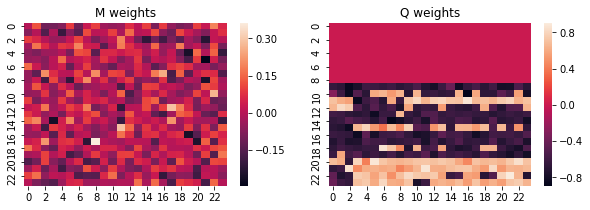

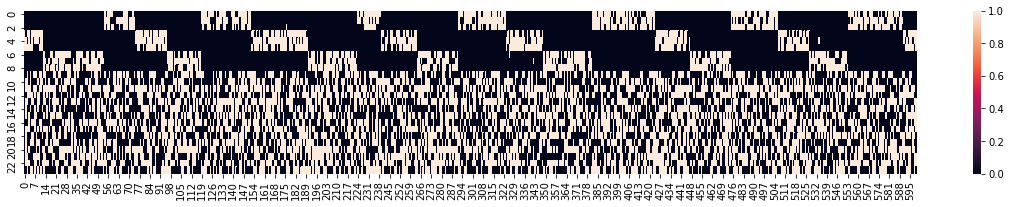

iter: 1, M: -1730727.40543, Q: -247211.237427


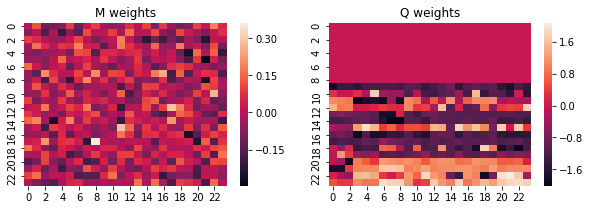

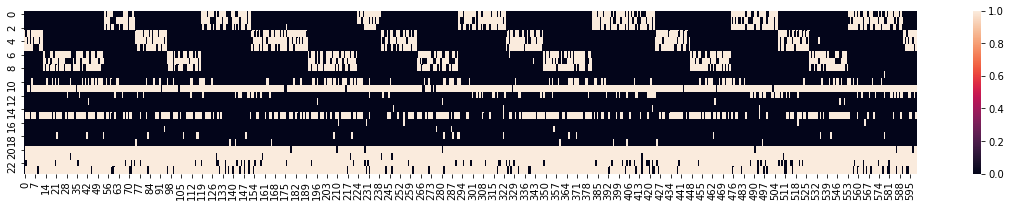

iter: 2, M: -1759434.92837, Q: -56399.9508445


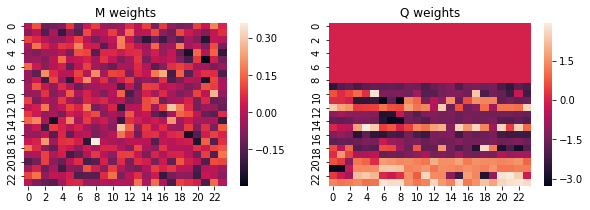

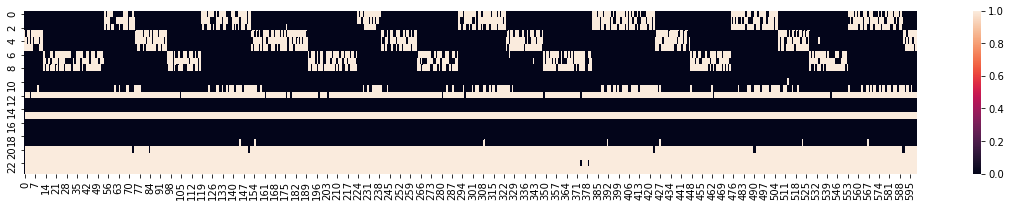

iter: 3, M: -1748285.12855, Q: -7290.41010043


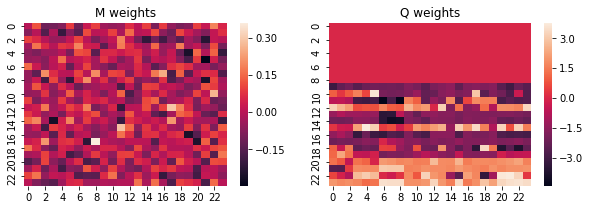

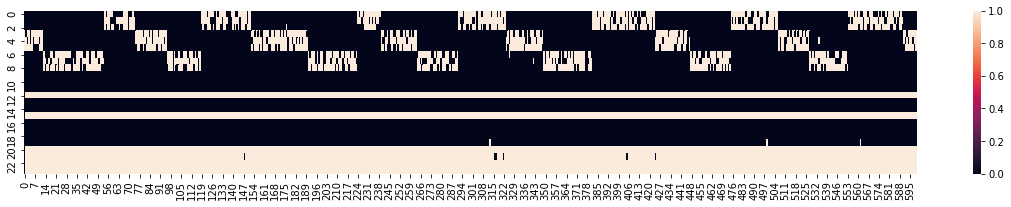

iter: 4, M: -1738152.05575, Q: -18199.3327821


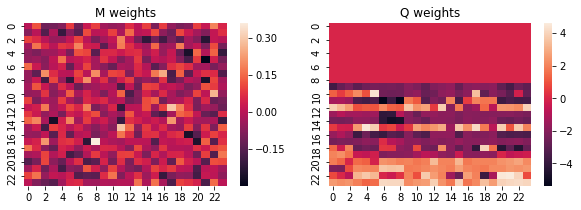

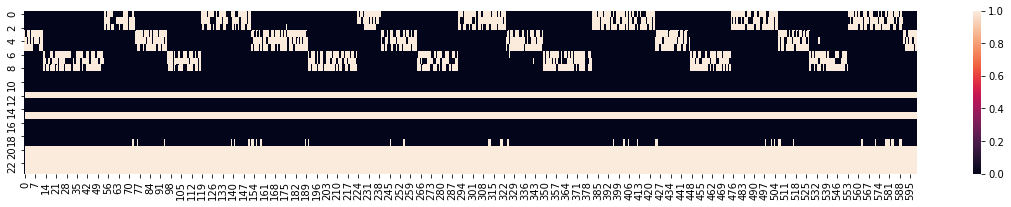

iter: 5, M: -1727361.51977, Q: -25278.1282106


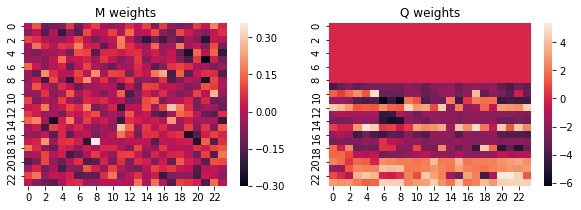

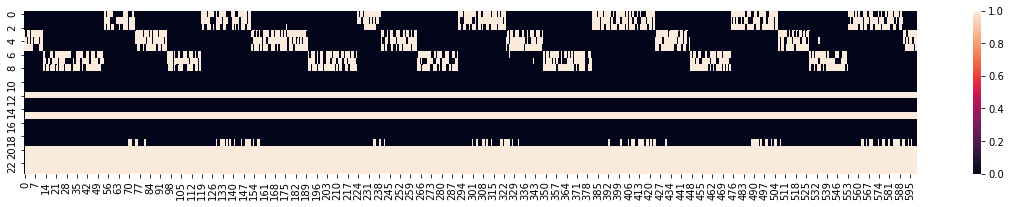

iter: 6, M: -1726599.69902, Q: -1559.14203473


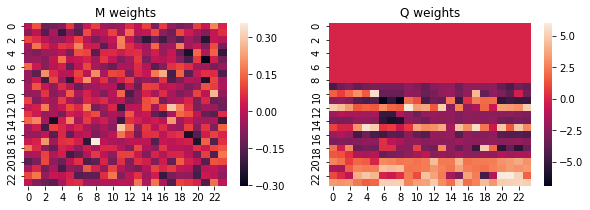

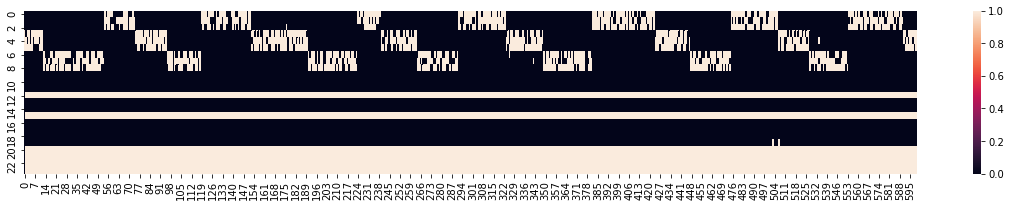

iter: 7, M: -1718967.08319, Q: -56.9568176499


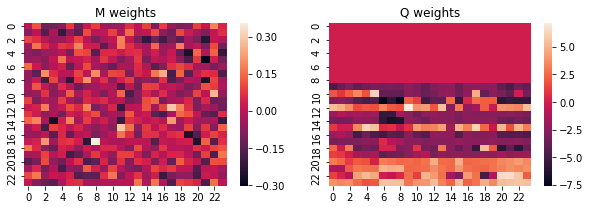

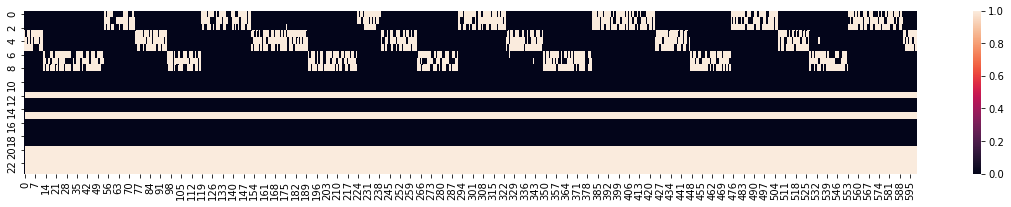

iter: 8, M: -1711112.58438, Q: -30.6183779504


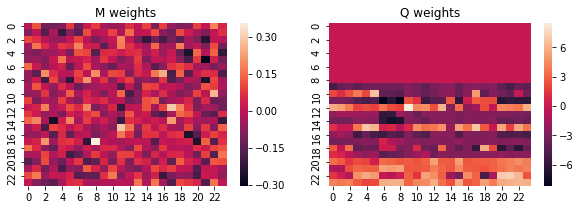

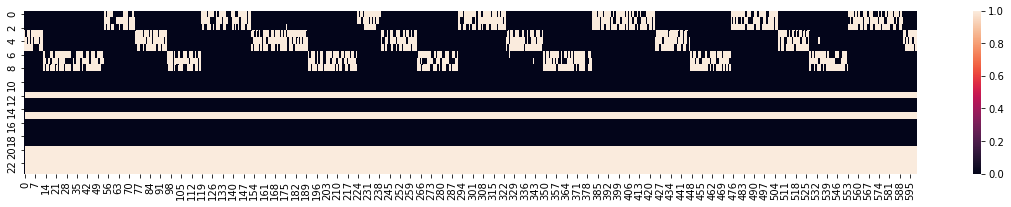

iter: 9, M: -1703214.80068, Q: -4.0273343584


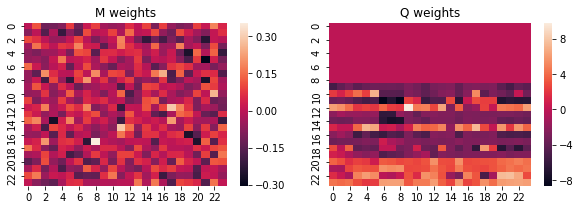

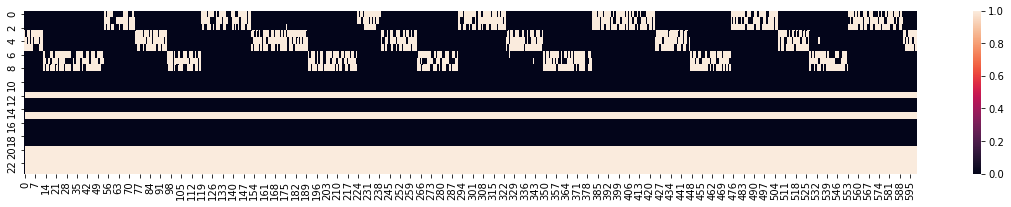

iter: 10, M: -1695293.05704, Q: -59.5646272218


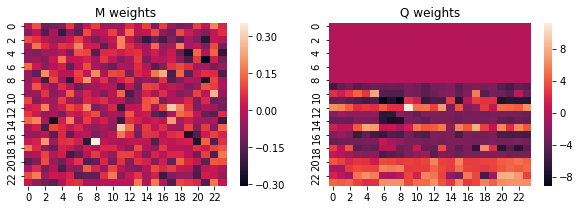

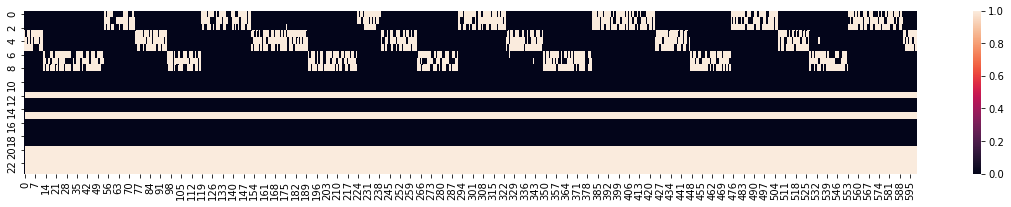

iter: 11, M: -1687366.83236, Q: -58.3840153352


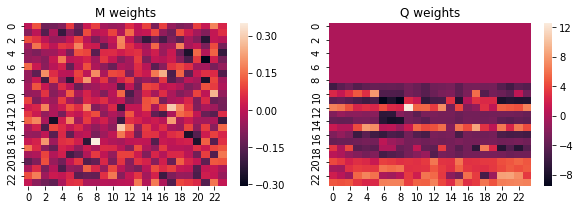

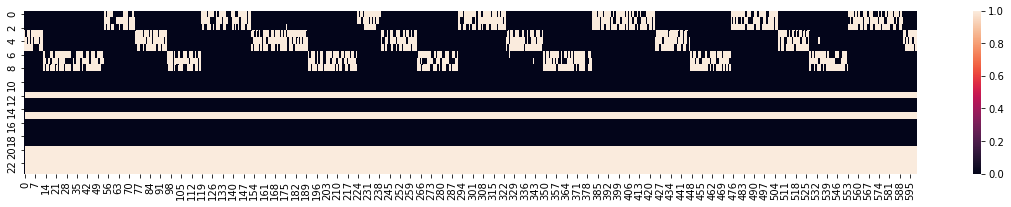

iter: 12, M: -1679437.70493, Q: -249.797393429


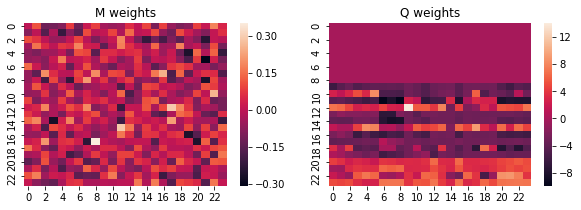

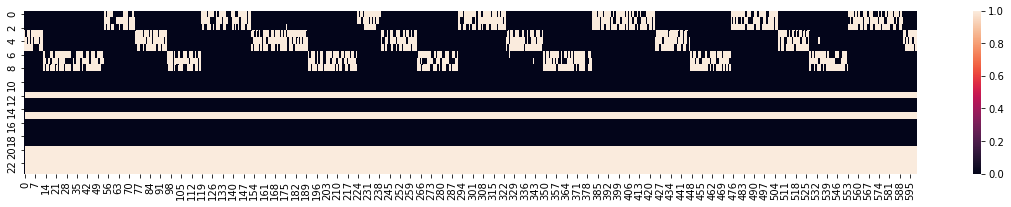

iter: 13, M: -1671524.63628, Q: -354.158961798


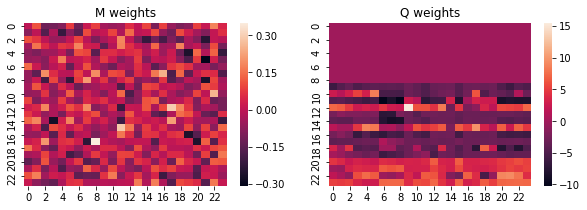

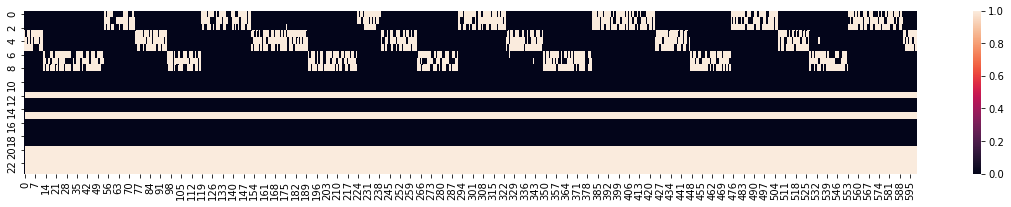

iter: 14, M: -1663640.37839, Q: -229.729834616


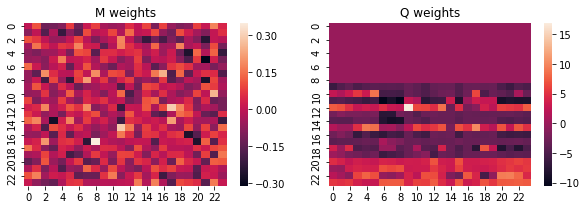

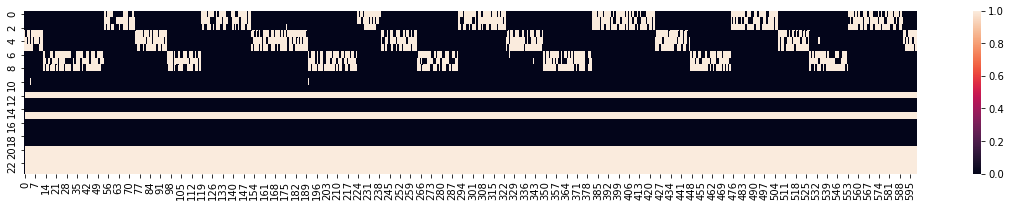

iter: 15, M: -1655778.2246, Q: -197.748012936


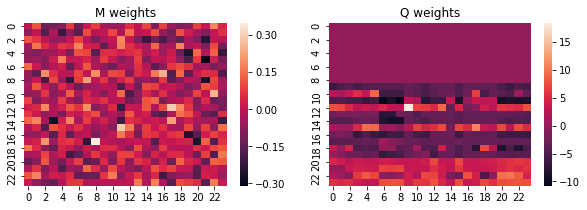

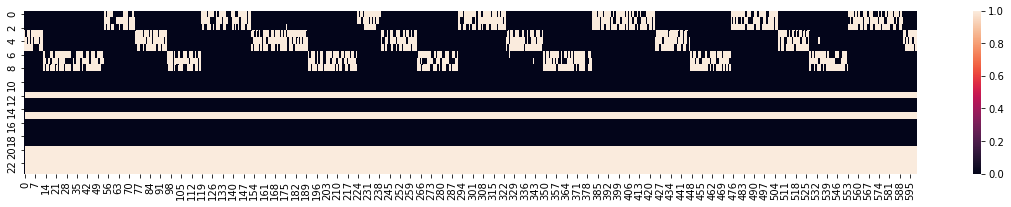

iter: 16, M: -1647946.21327, Q: -113.055615354


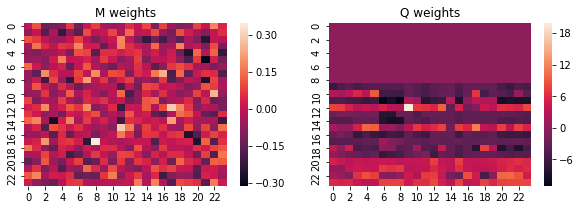

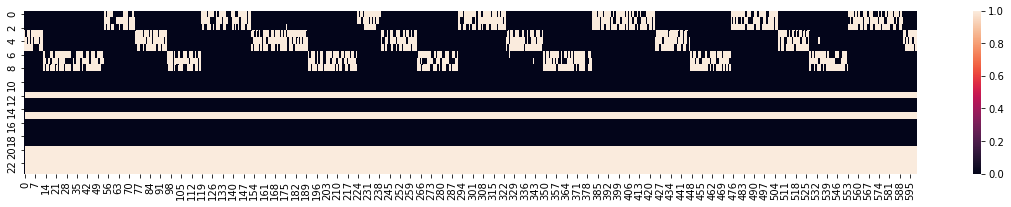

iter: 17, M: -1640146.77113, Q: -26.3123759789


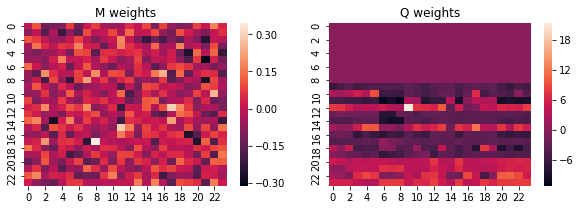

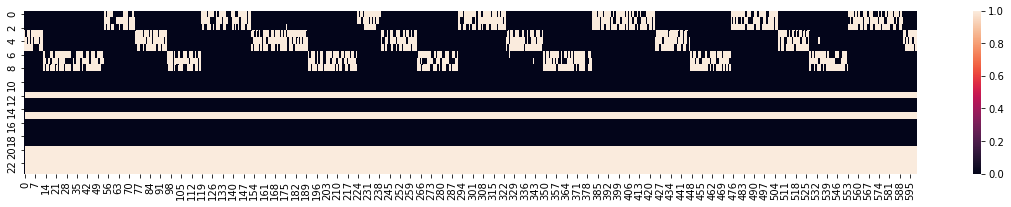

iter: 18, M: -1632380.49071, Q: -15.9767984651


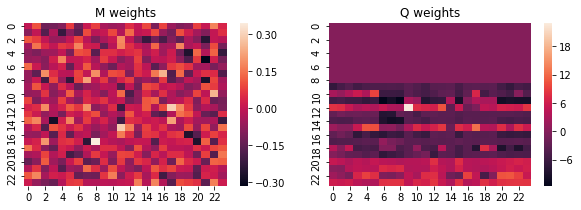

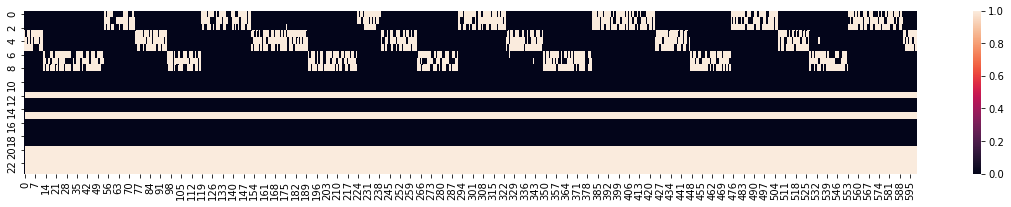

iter: 19, M: -1624652.06937, Q: -16.375263798


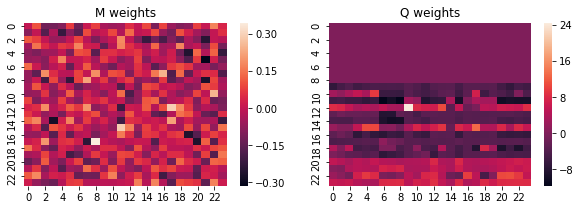

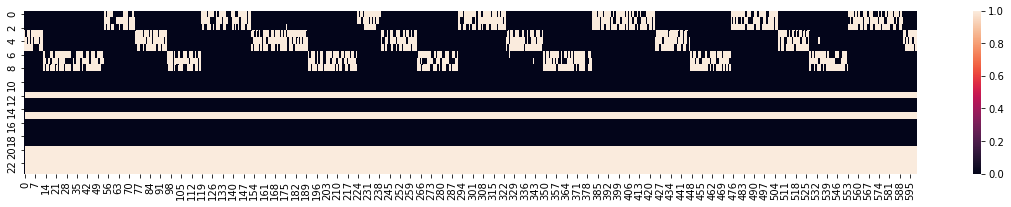

iter: 20, M: -1616963.93419, Q: -6.3713989797


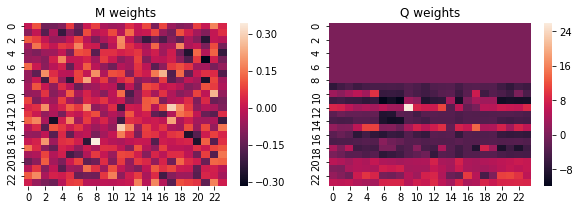

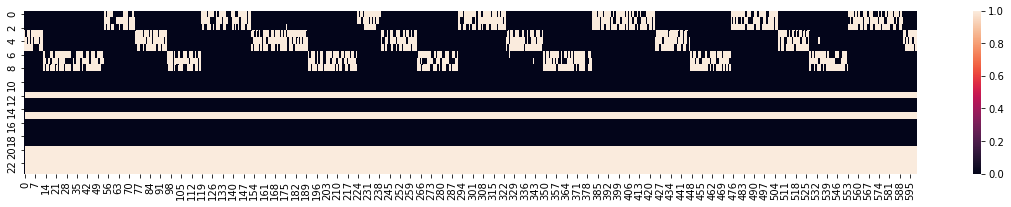

iter: 21, M: -1609317.41635, Q: -6.21710899853


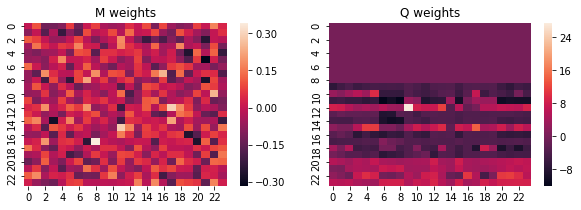

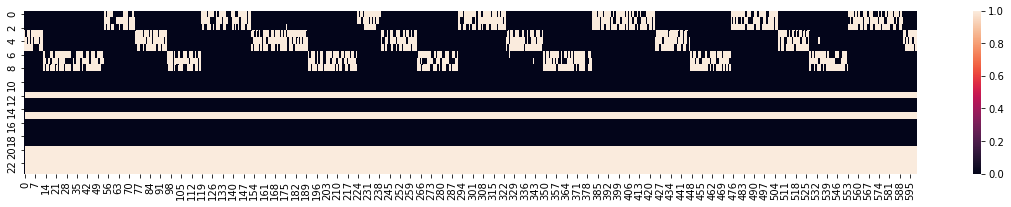

iter: 22, M: -1601713.95182, Q: -16.9443333673


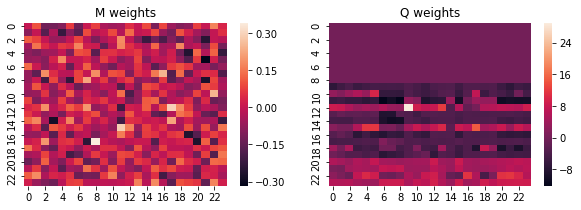

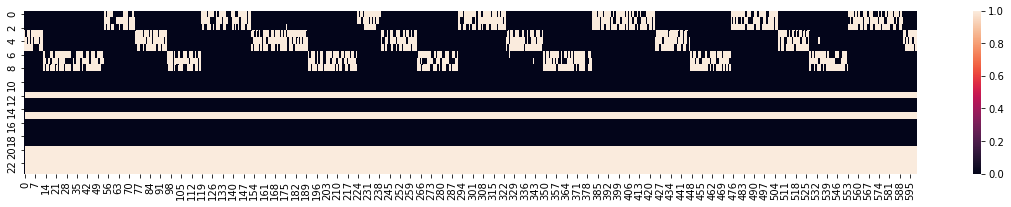

iter: 23, M: -1594155.32491, Q: -6.07846734097


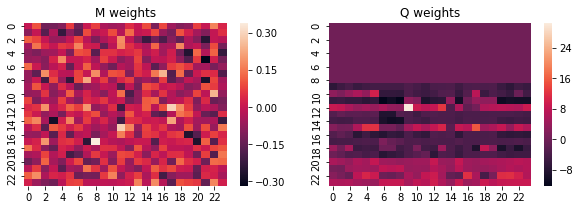

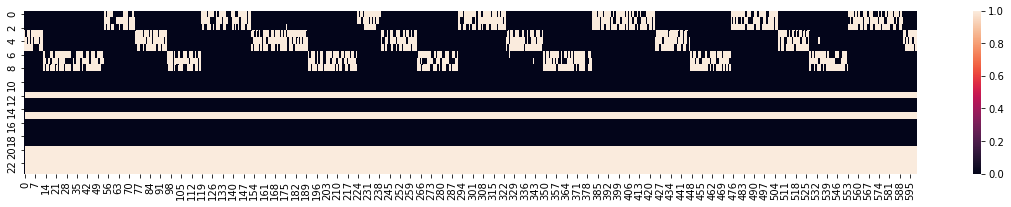

iter: 24, M: -1586641.98706, Q: -6.04745816814


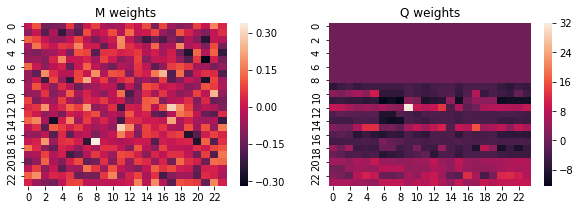

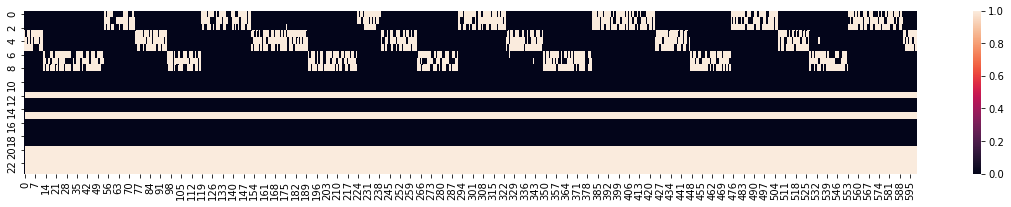

iter: 25, M: -1579174.98744, Q: -6.03041702065


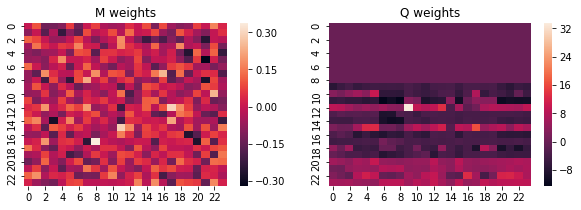

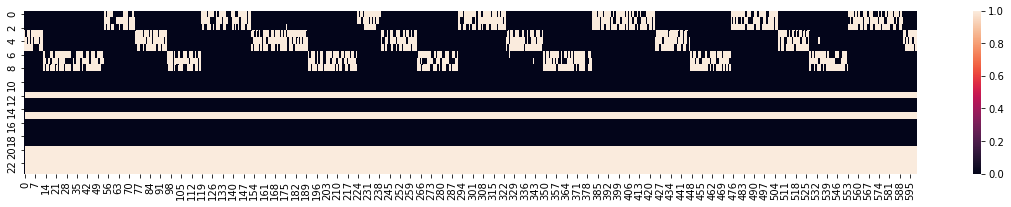

iter: 26, M: -1571755.04426, Q: -6.02048098134


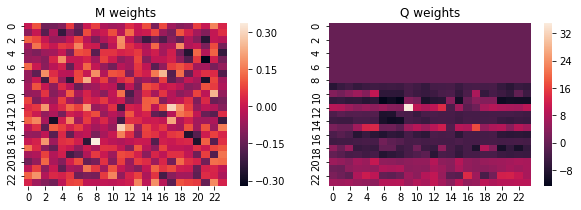

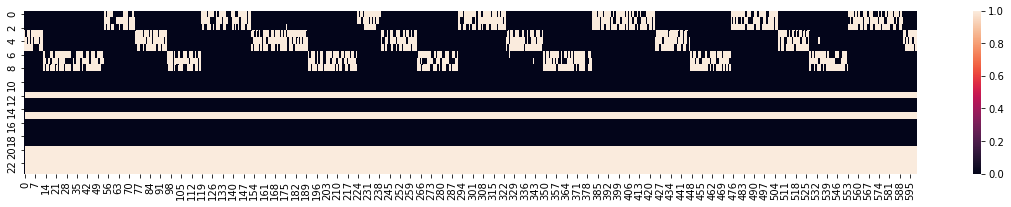

iter: 27, M: -1564382.75371, Q: -6.01439369158


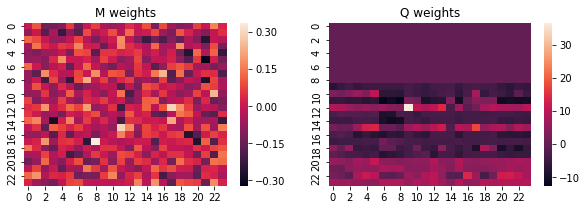

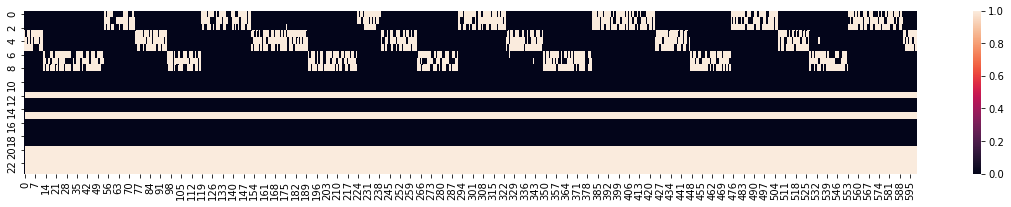

iter: 28, M: -1557058.60574, Q: -6.0105026821


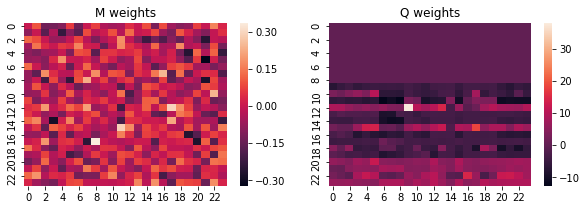

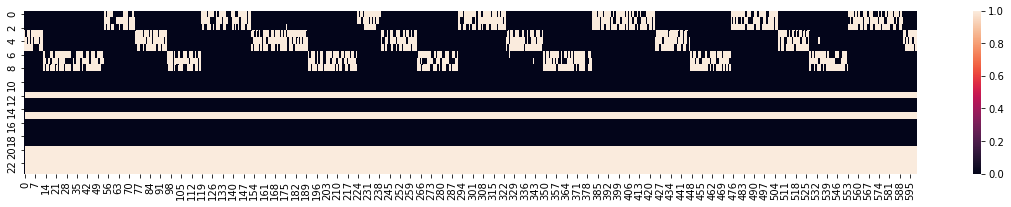

iter: 29, M: -1549782.99751, Q: -6.00792191291


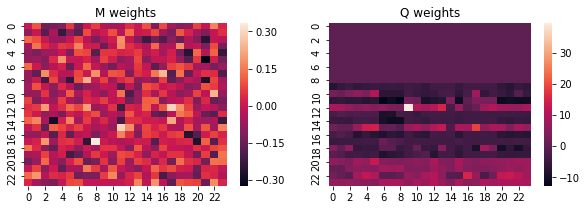

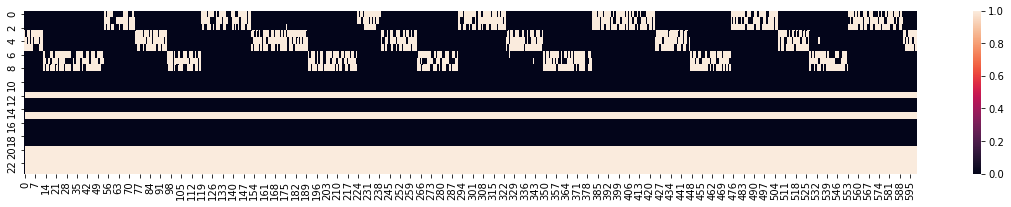

iter: 30, M: -1542556.24484, Q: -6.0061536189


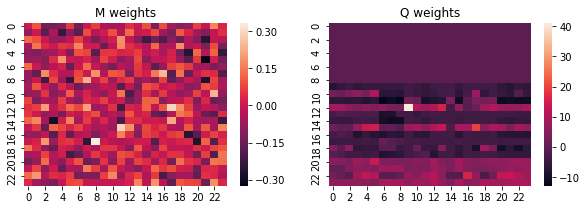

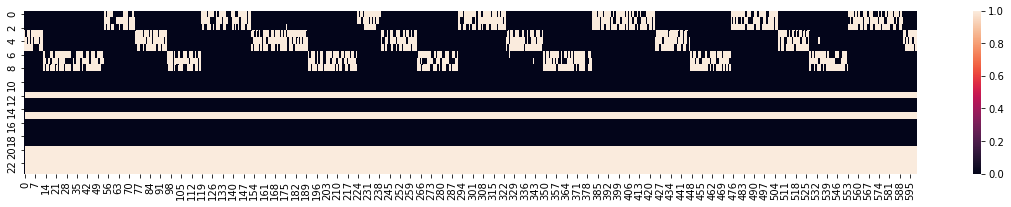

iter: 31, M: -1535378.59214, Q: -6.00490663411


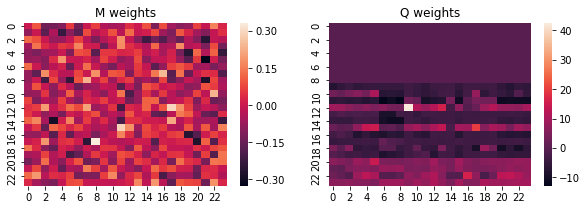

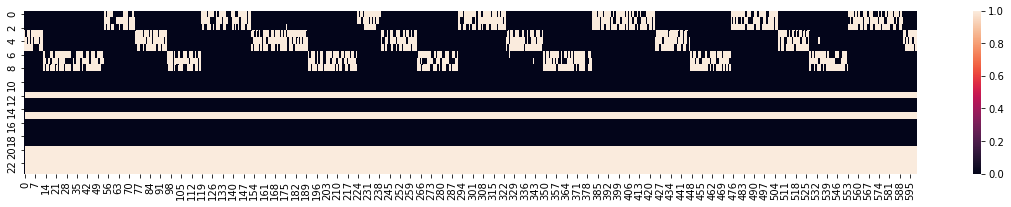

iter: 32, M: -1528250.22091, Q: -6.00400447308


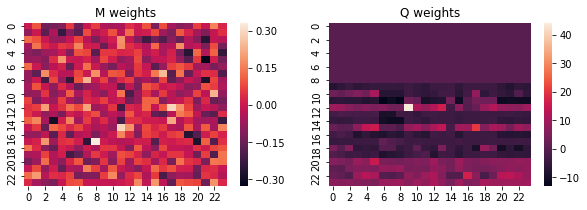

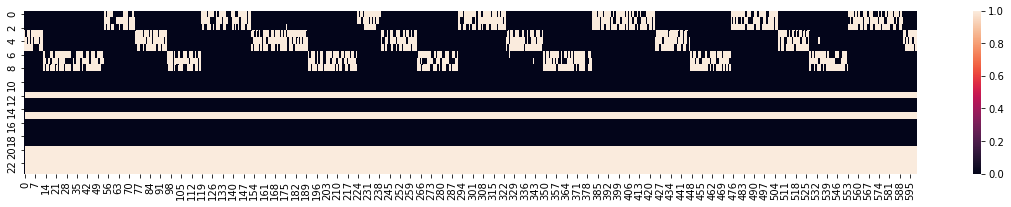

iter: 33, M: -1521171.25714, Q: -6.00333671554


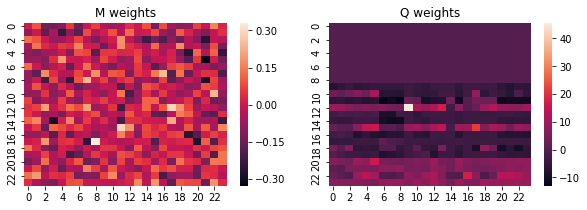

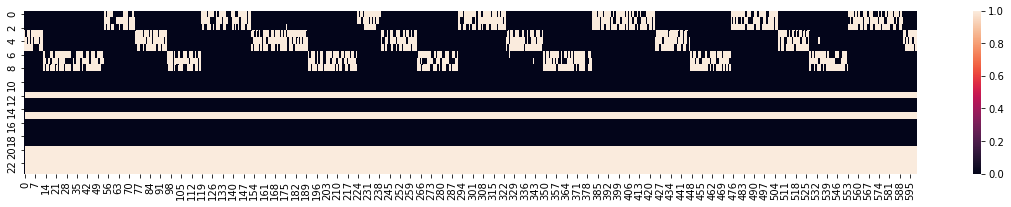

iter: 34, M: -1514141.77771, Q: -6.00283227783


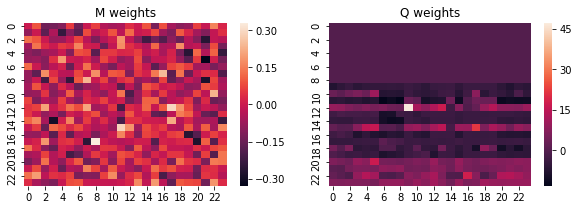

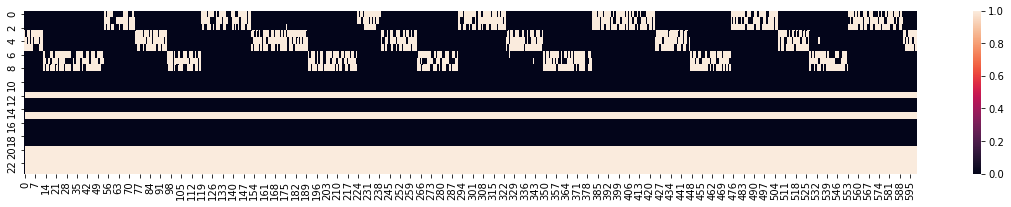

iter: 35, M: -1507161.81592, Q: -6.00244420343


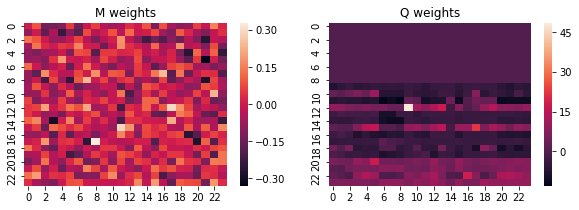

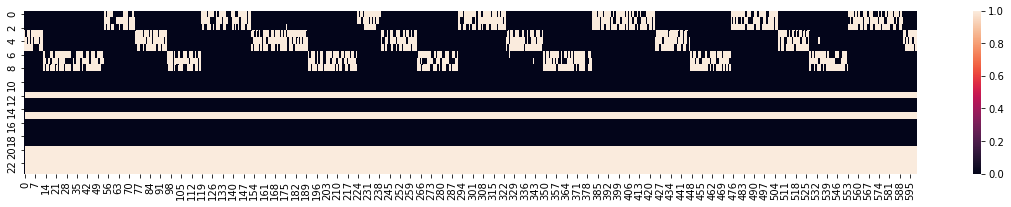

iter: 36, M: -1500231.36634, Q: -6.00214073717


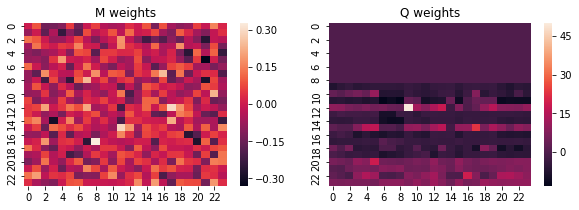

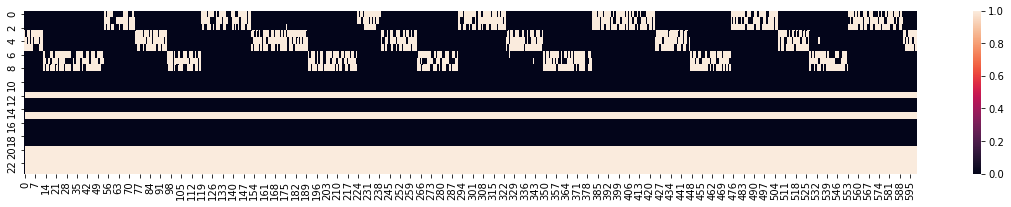

iter: 37, M: -1493350.38896, Q: -6.00189993874


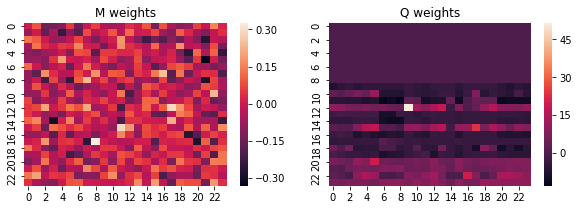

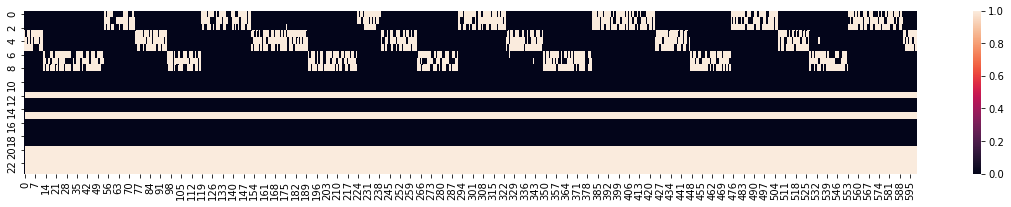

iter: 38, M: -1486518.81288, Q: -6.00170634838


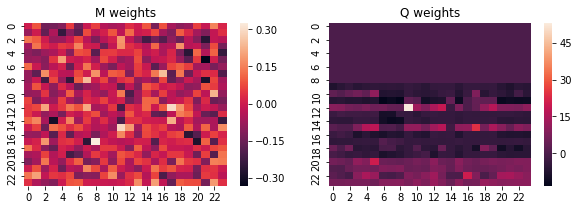

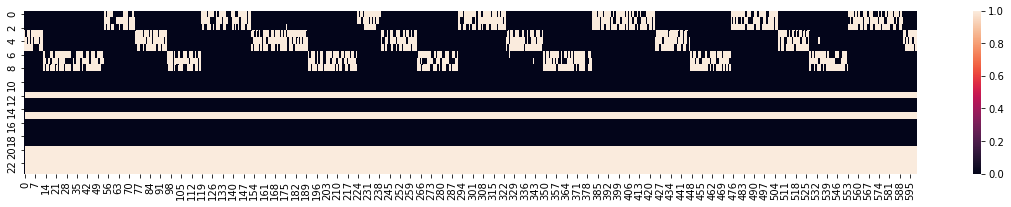

iter: 39, M: -1479736.53945, Q: -6.00154887415


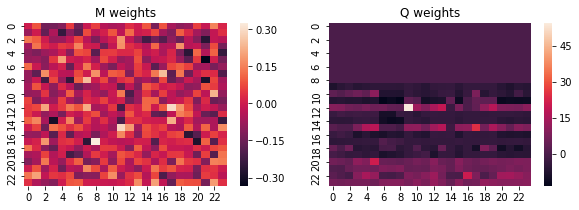

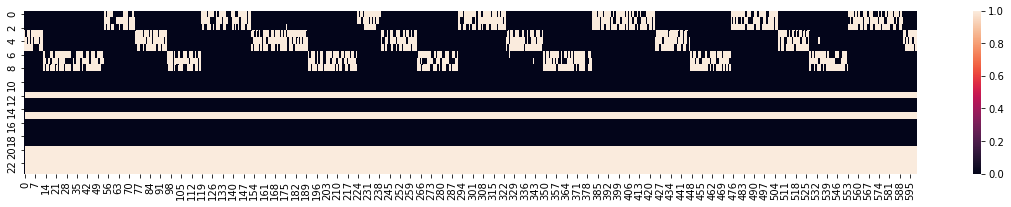

iter: 40, M: -1473003.44511, Q: -6.00141942441


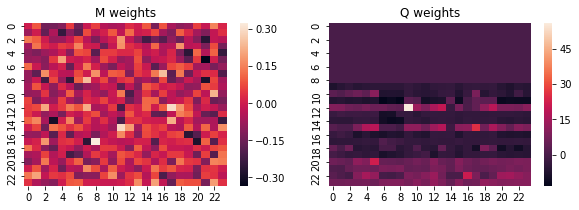

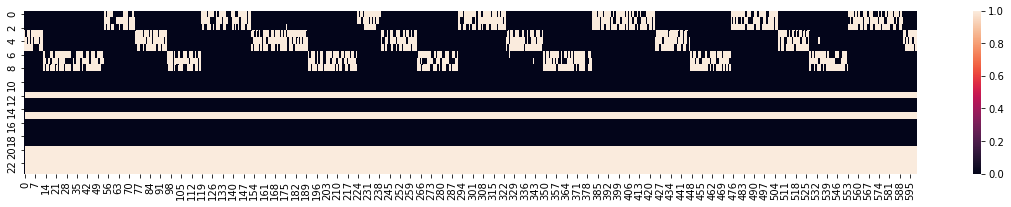

iter: 41, M: -1466319.38385, Q: -6.00131200476


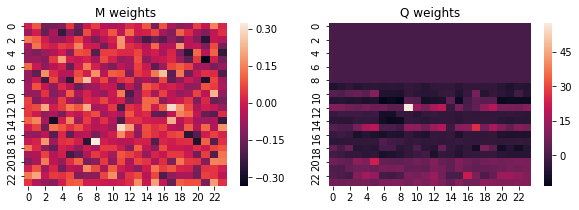

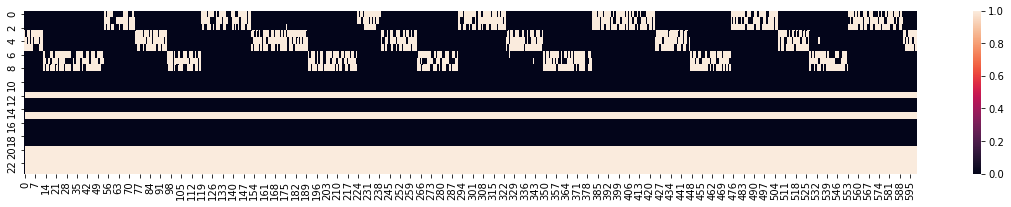

iter: 42, M: -1459684.1894, Q: -6.00122211085


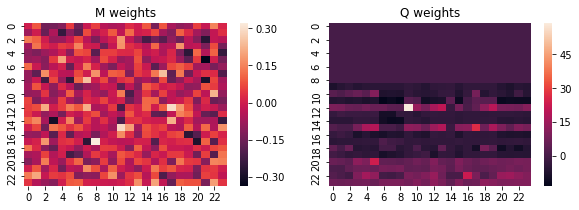

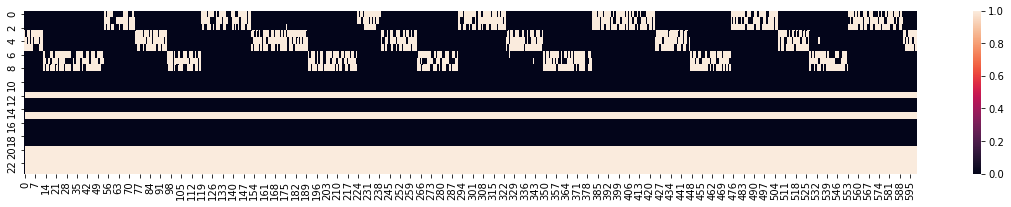

iter: 43, M: -1453097.67719, Q: -6.00114631305


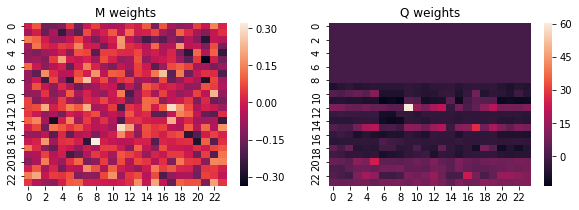

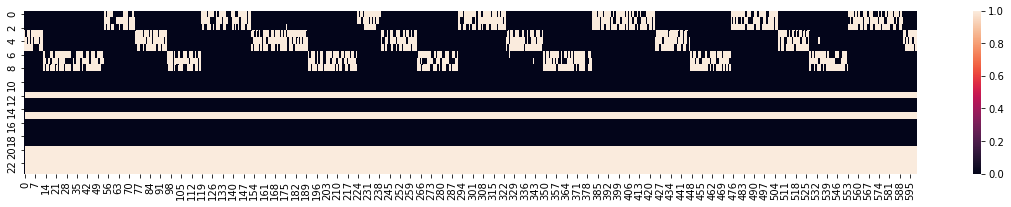

iter: 44, M: -1446559.64611, Q: -6.00108196774


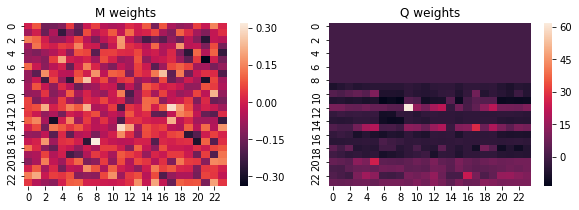

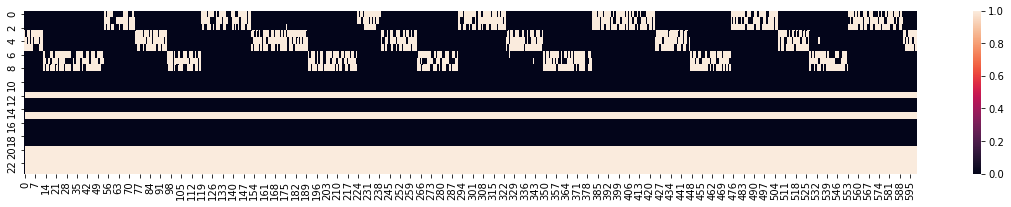

iter: 45, M: -1440069.8801, Q: -6.00102701385


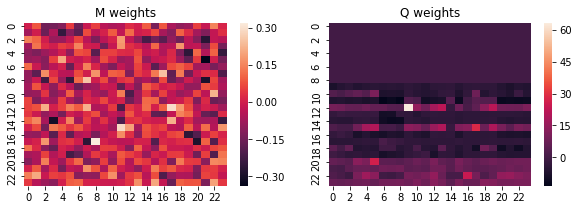

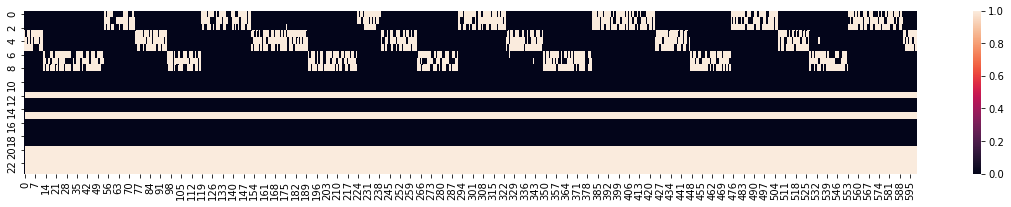

iter: 46, M: -1433628.14956, Q: -6.00097982726


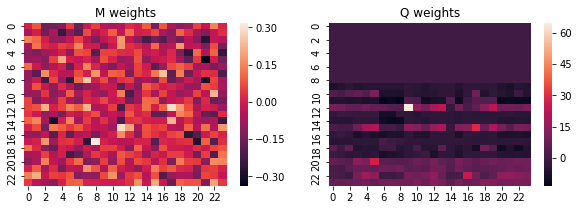

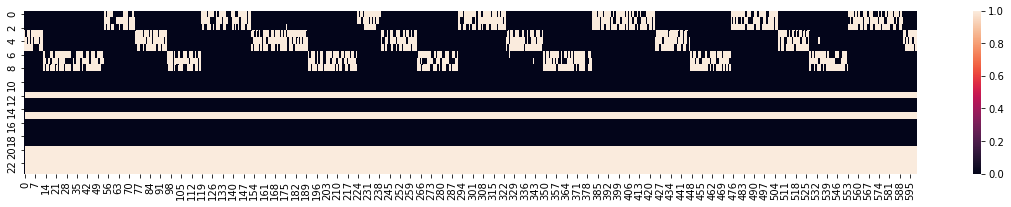

iter: 47, M: -1427234.21271, Q: -6.00093911543


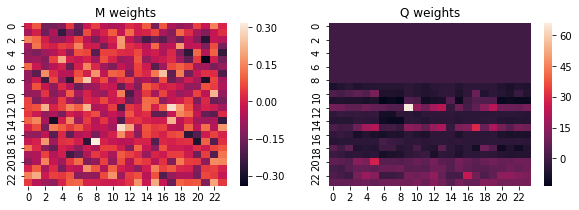

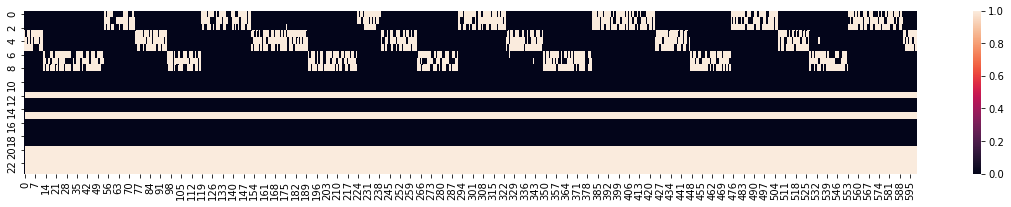

iter: 48, M: -1420887.81675, Q: -6.00090384005


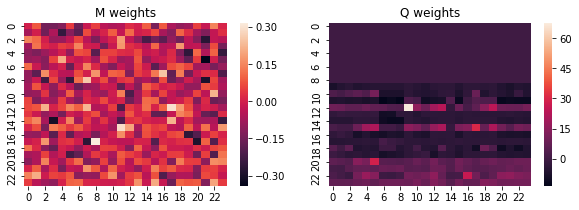

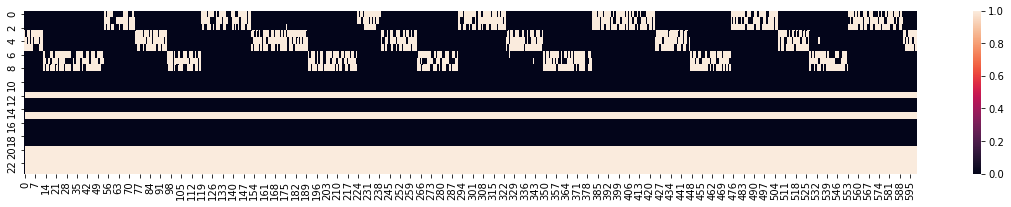

iter: 49, M: -1414588.699, Q: -6.00087315985


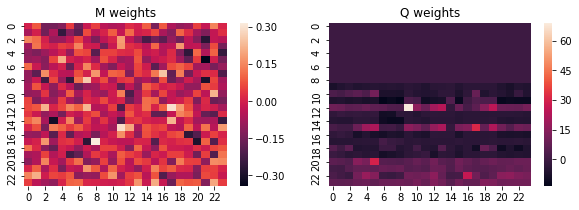

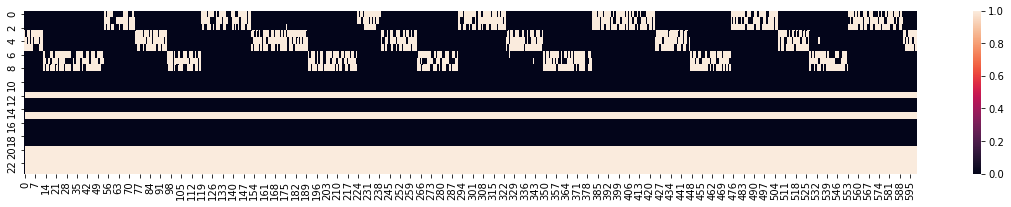

iter: 50, M: -1408336.58786, Q: -6.00084638757


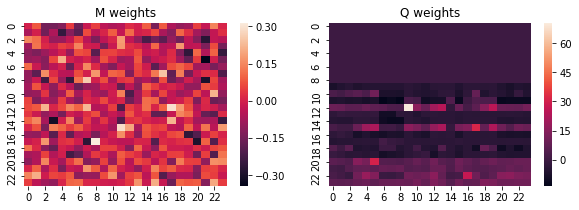

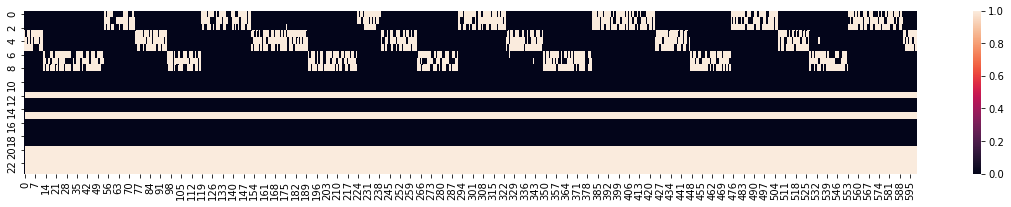

iter: 51, M: -1402131.20381, Q: -6.00082295754


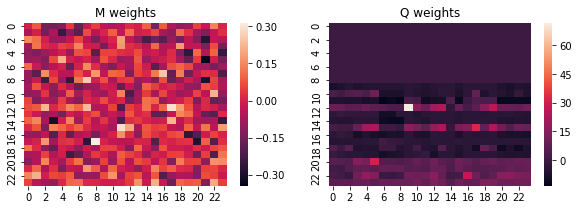

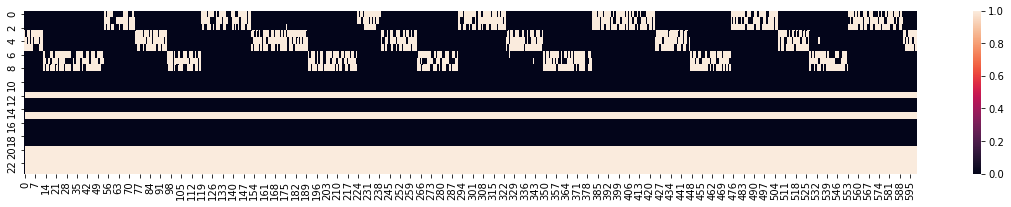

iter: 52, M: -1395972.26021, Q: -6.00080240077


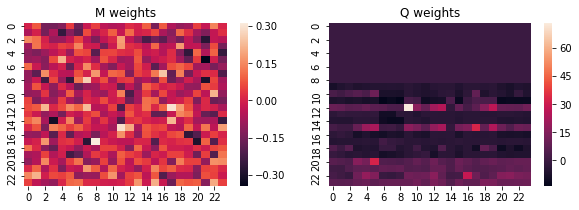

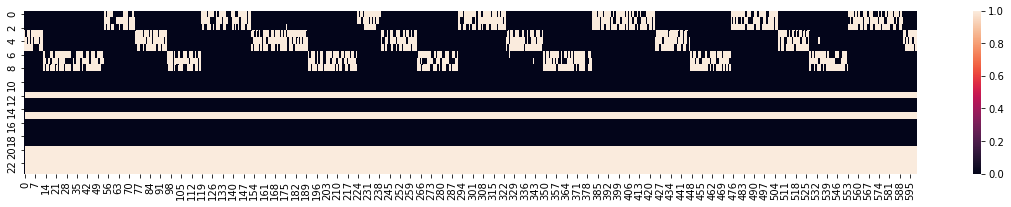

iter: 53, M: -1389859.46415, Q: -6.00078432589


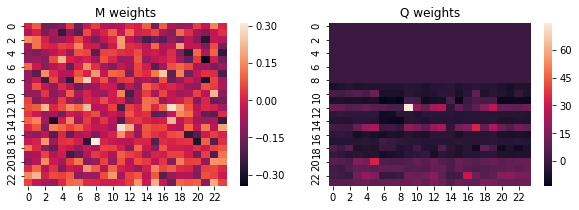

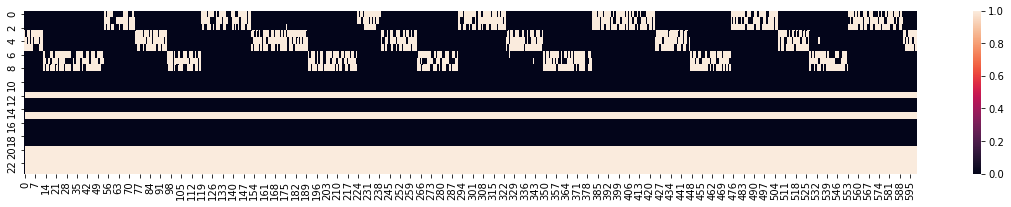

iter: 54, M: -1383792.51715, Q: -6.00076840421


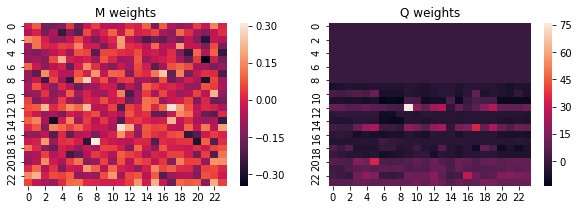

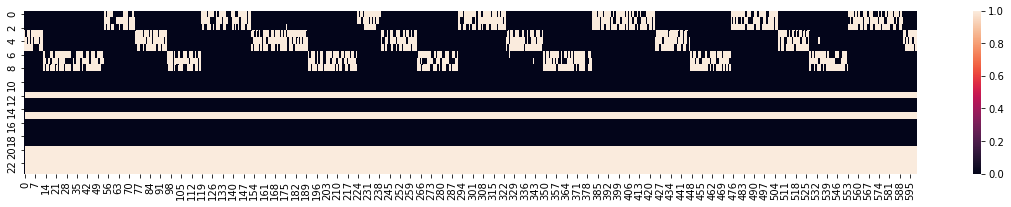

iter: 55, M: -1377771.11586, Q: -6.00075435807


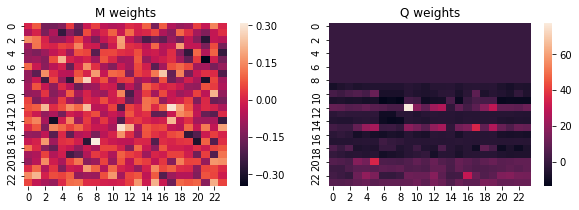

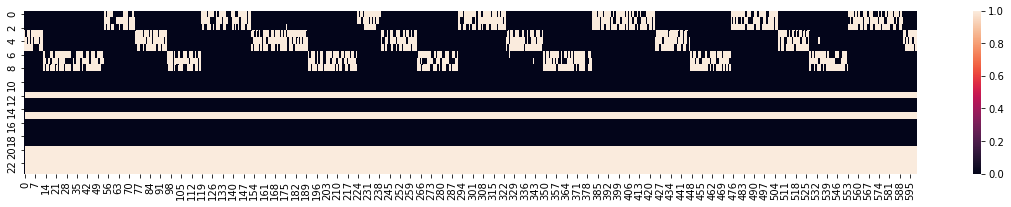

iter: 56, M: -1371794.95267, Q: -6.00074195162


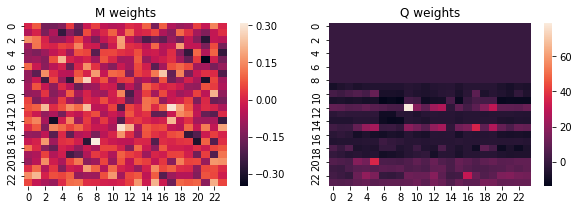

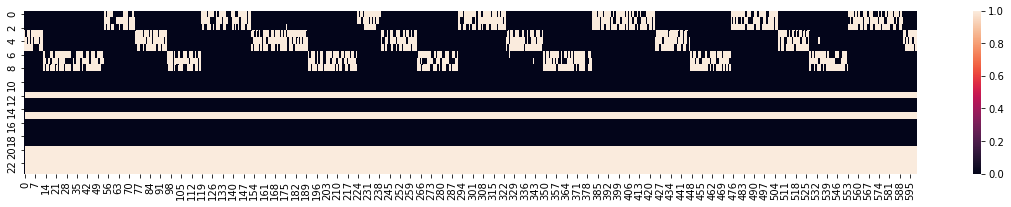

iter: 57, M: -1365863.71634, Q: -6.00073098353


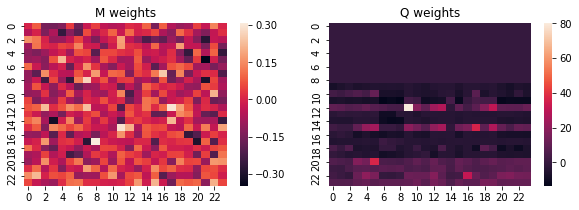

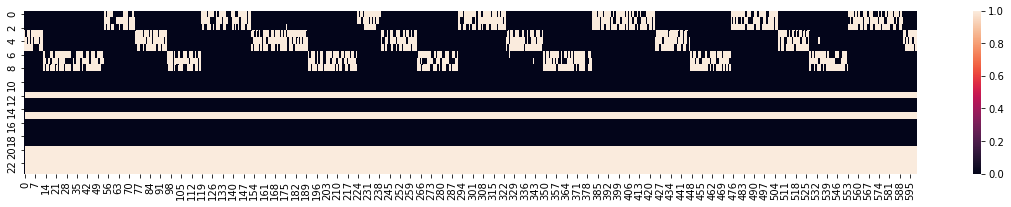

iter: 58, M: -1359977.09247, Q: -6.00072128106


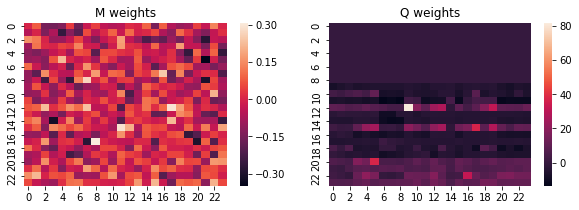

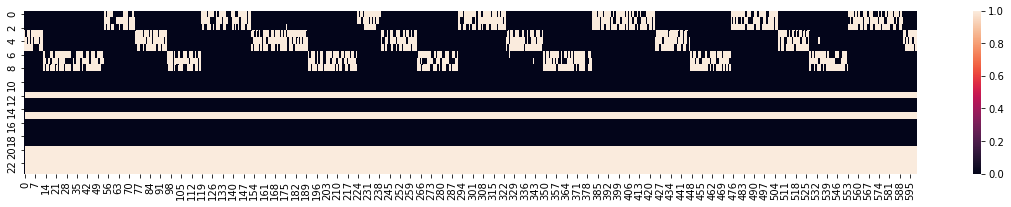

iter: 59, M: -1354134.76406, Q: -6.00071269538


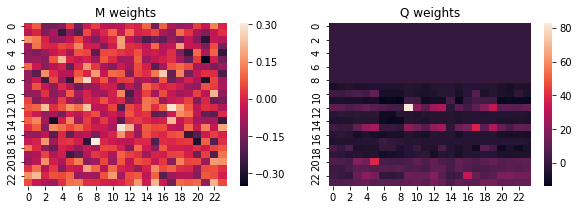

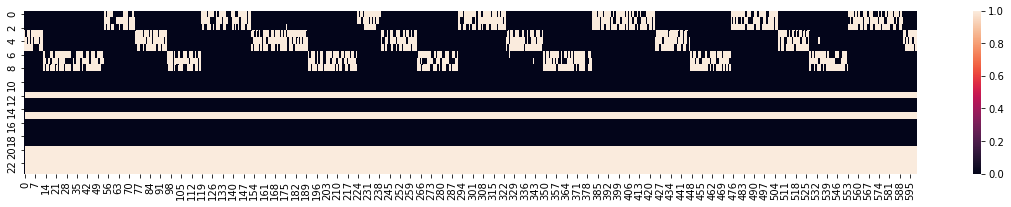

iter: 60, M: -1348336.41195, Q: -6.00070509771


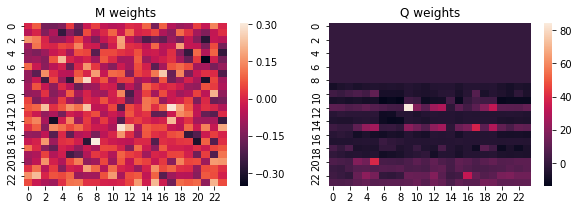

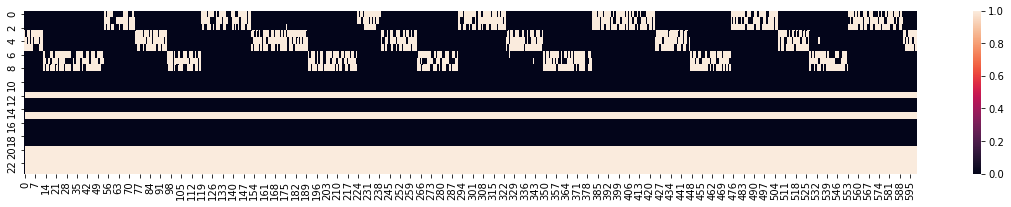

iter: 61, M: -1342581.71523, Q: -6.00069837619


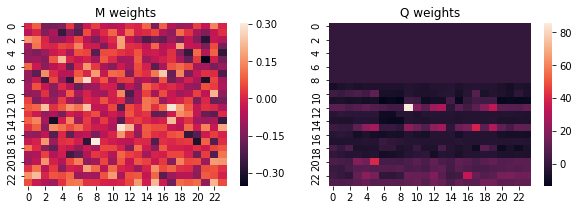

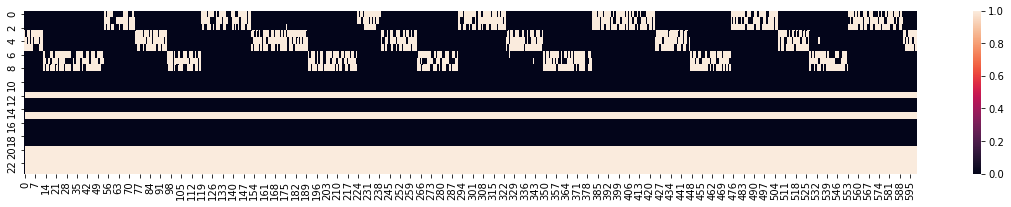

iter: 62, M: -1336870.35166, Q: -6.0006924333


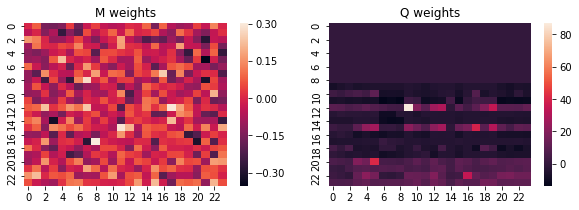

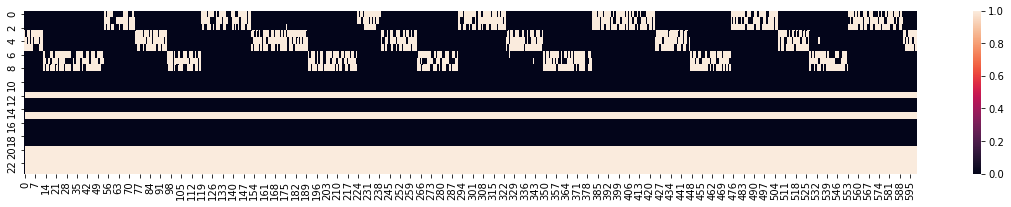

iter: 63, M: -1331201.99799, Q: -6.00068718374


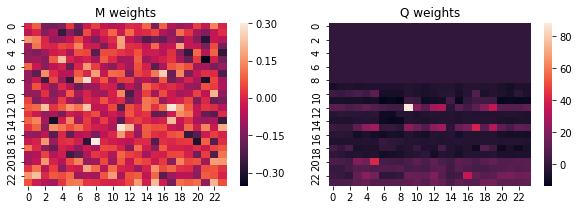

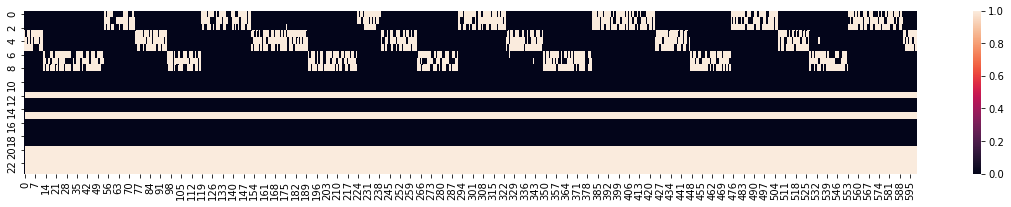

iter: 64, M: -1325576.33037, Q: -6.00068255267


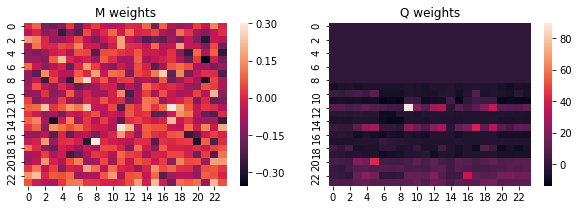

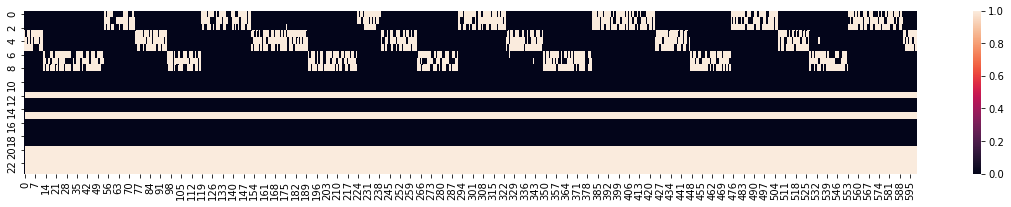

iter: 65, M: -1319993.02457, Q: -6.00067847427


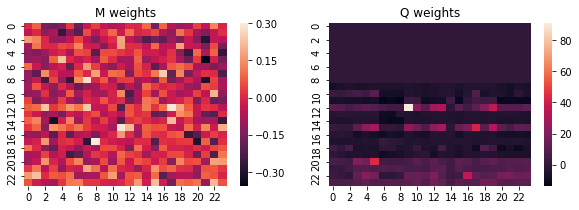

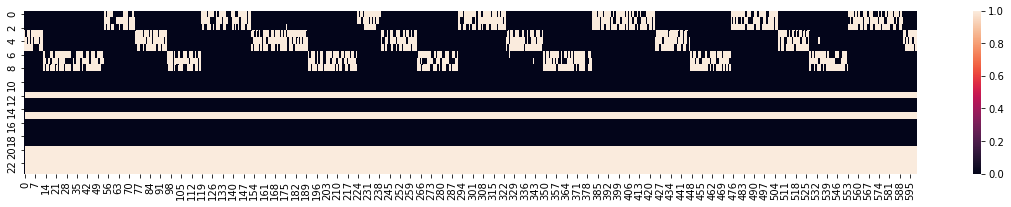

iter: 66, M: -1314451.75633, Q: -6.00067489043


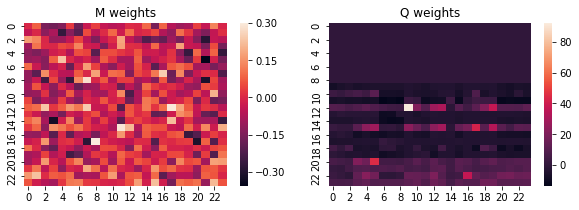

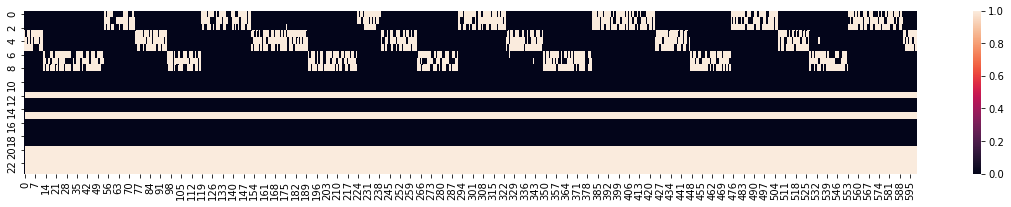

iter: 67, M: -1308952.20156, Q: -6.0006717498


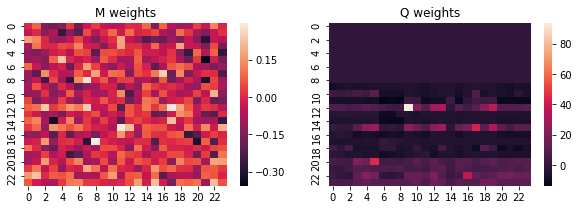

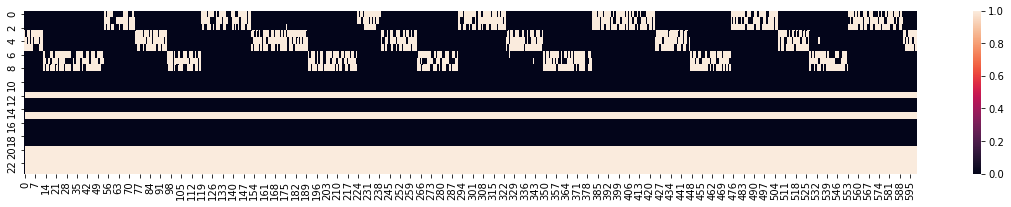

iter: 68, M: -1303494.03664, Q: -6.00066900684


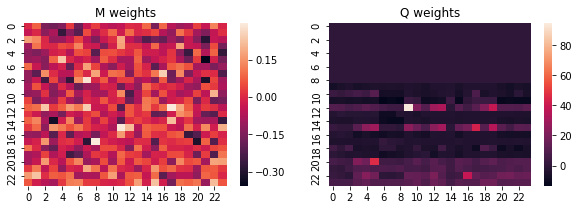

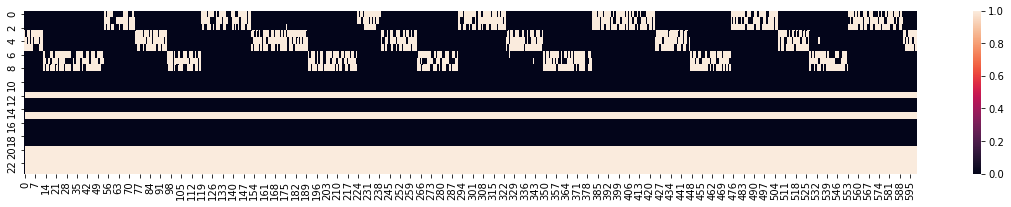

iter: 69, M: -1298076.9386, Q: -6.00066662112


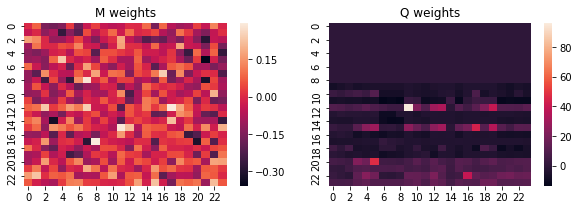

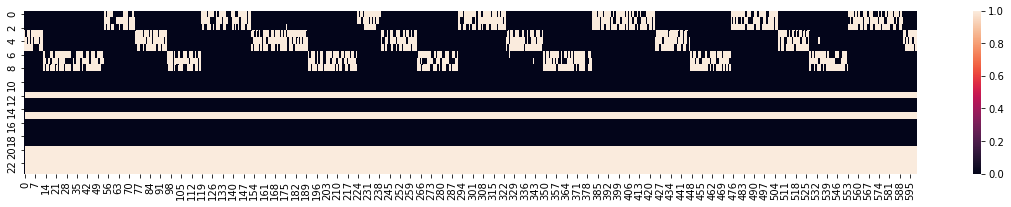

iter: 70, M: -1292700.5853, Q: -6.00066455666


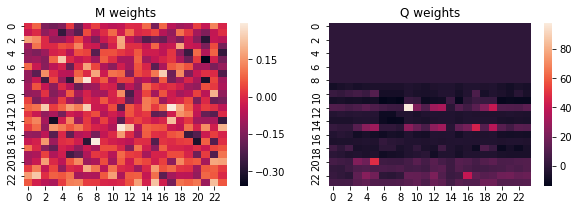

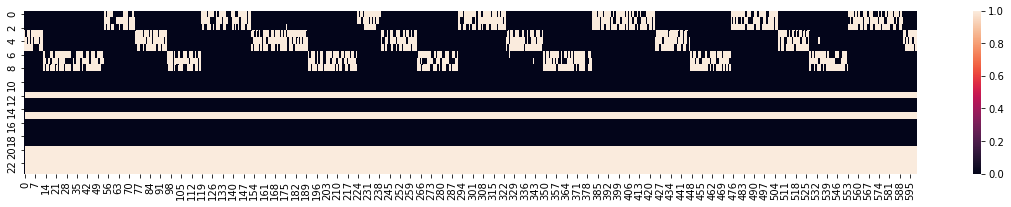

iter: 71, M: -1287364.65566, Q: -6.0006627814


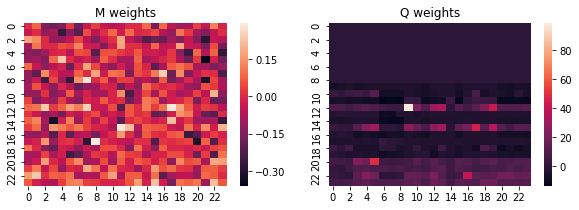

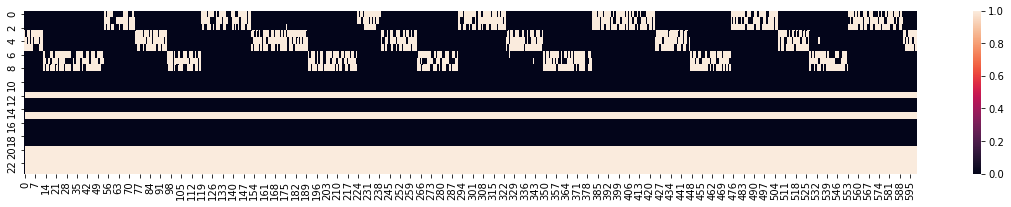

iter: 72, M: -1282068.82979, Q: -6.00066126672


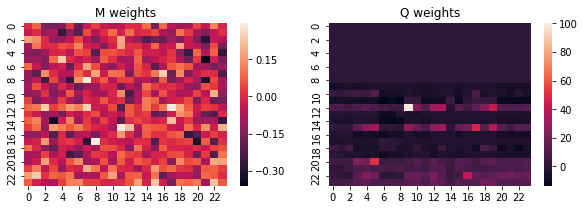

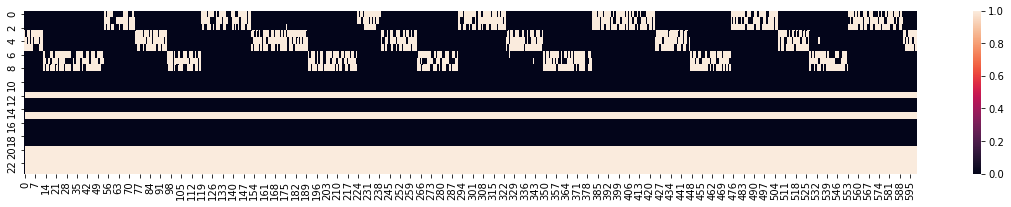

iter: 73, M: -1276812.78911, Q: -6.00065998702


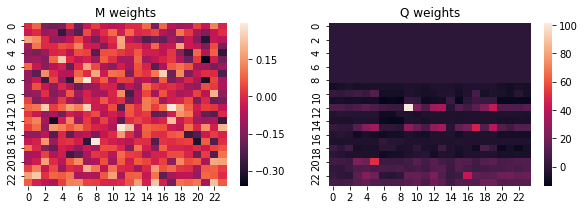

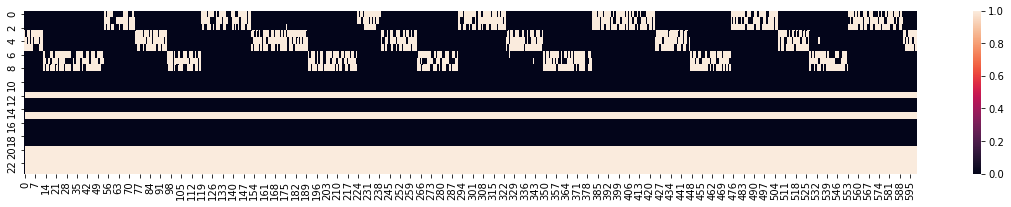

iter: 74, M: -1271596.21655, Q: -6.00065891939


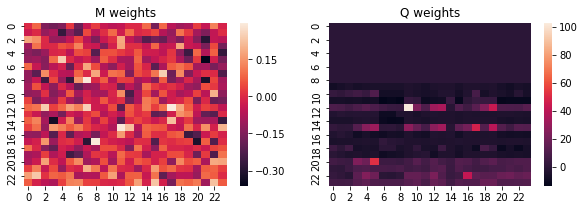

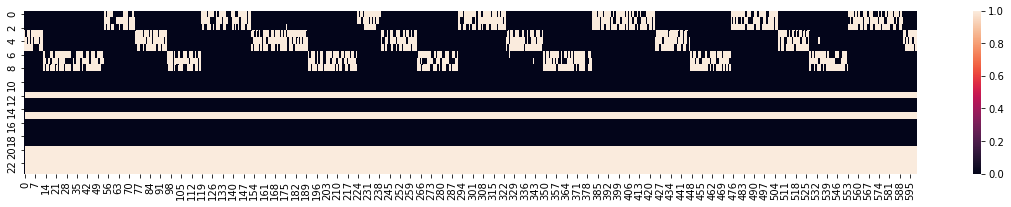

iter: 75, M: -1266418.79662, Q: -6.0006580433


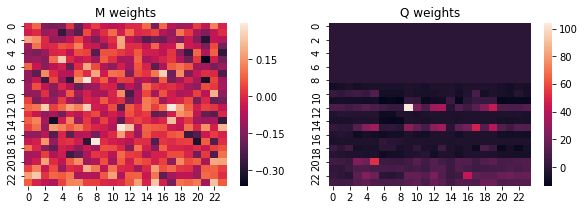

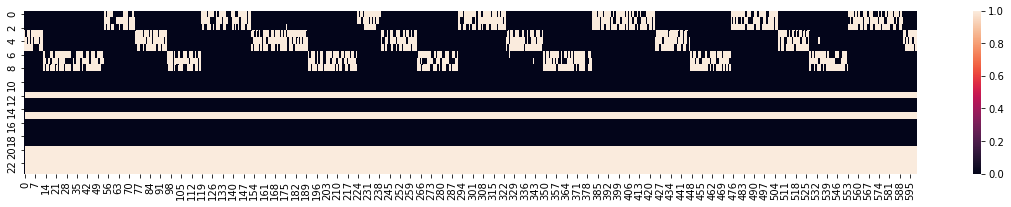

iter: 76, M: -1261280.21551, Q: -6.00065734034


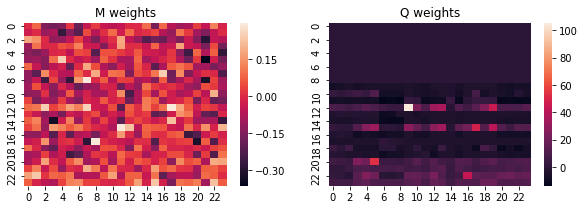

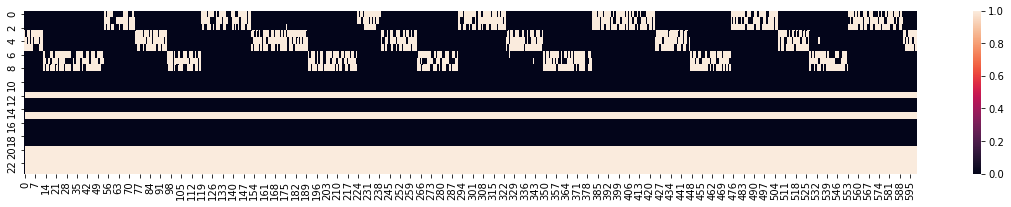

iter: 77, M: -1256180.16121, Q: -6.00065679396


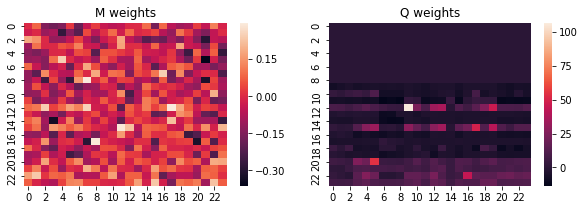

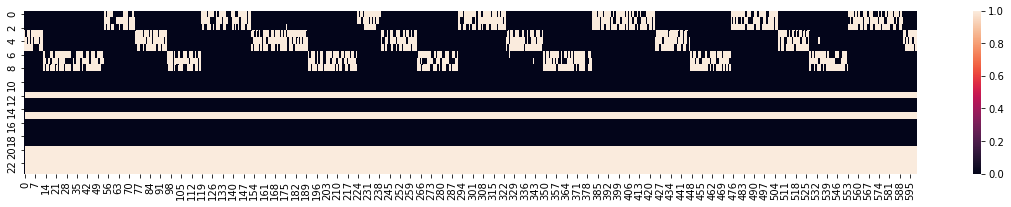

iter: 78, M: -1251118.32357, Q: -6.0006563893


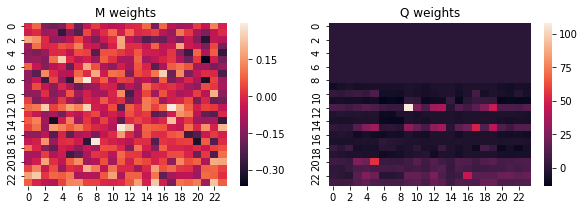

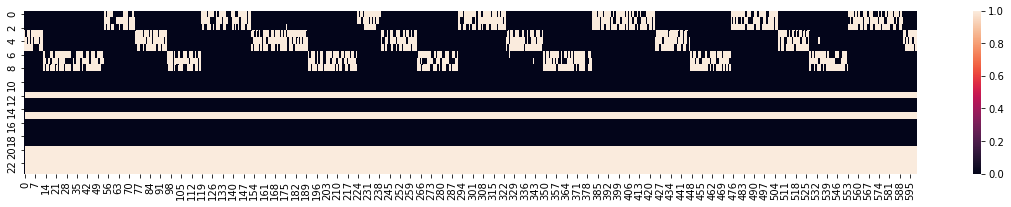

iter: 79, M: -1246094.39438, Q: -6.00065611297


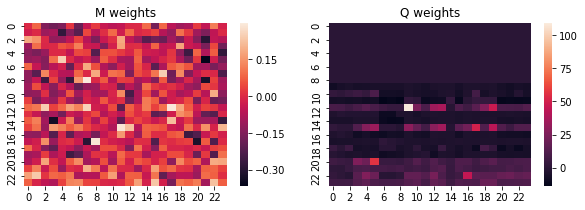

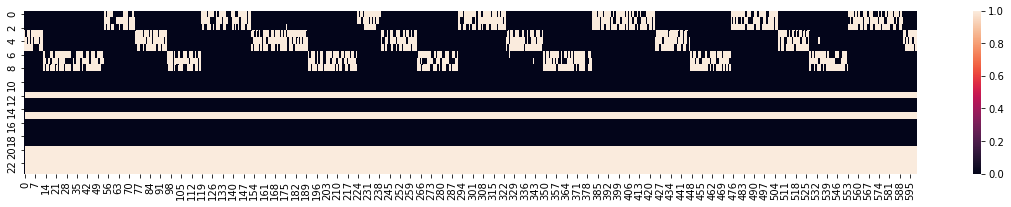

iter: 80, M: -1241108.06744, Q: -6.00065595295


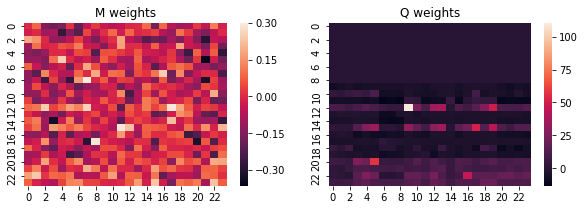

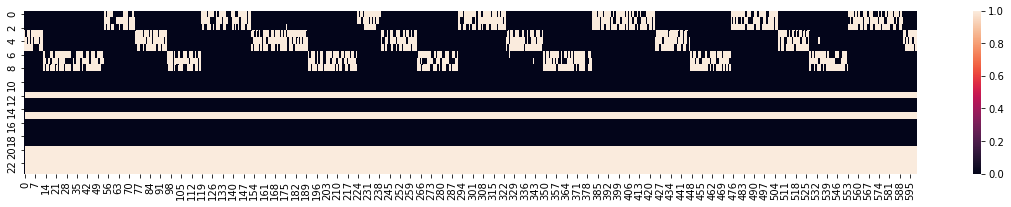

iter: 81, M: -1236159.03858, Q: -6.00065589839


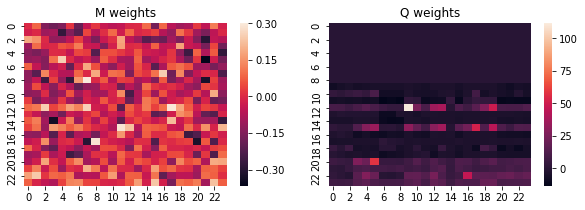

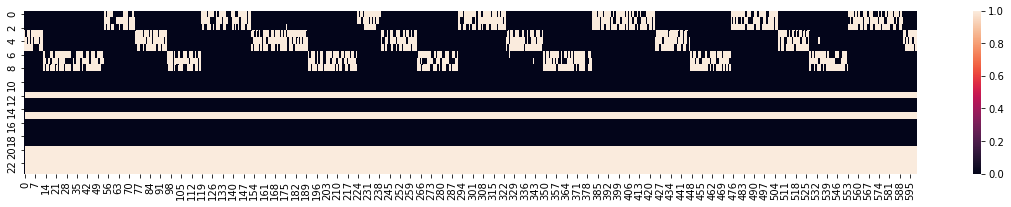

iter: 82, M: -1231247.00575, Q: -6.0006559395


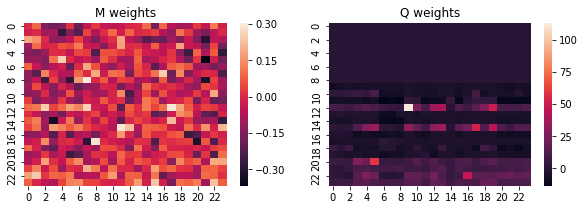

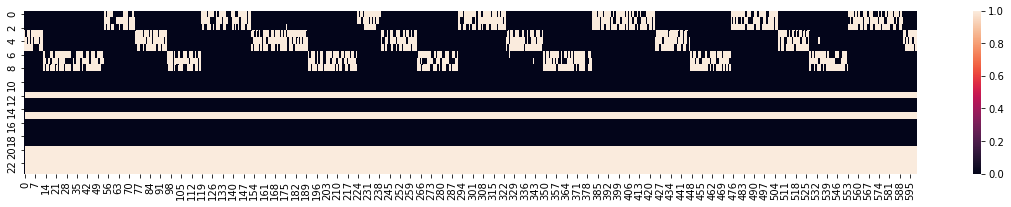

iter: 83, M: -1226371.66902, Q: -6.00065606748


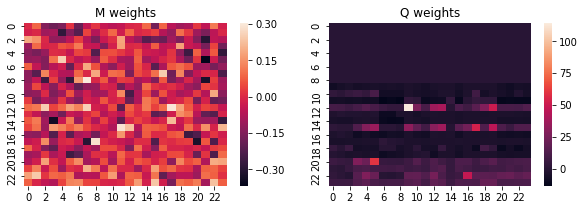

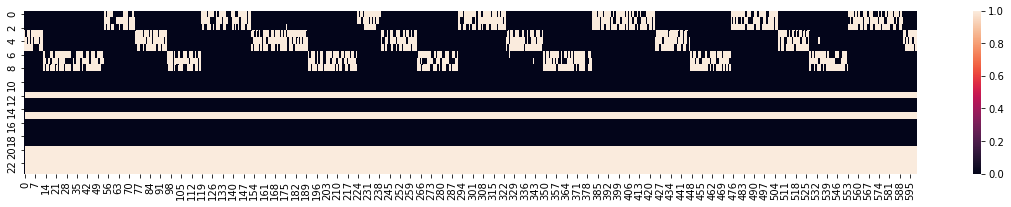

iter: 84, M: -1221532.7306, Q: -6.00065627437


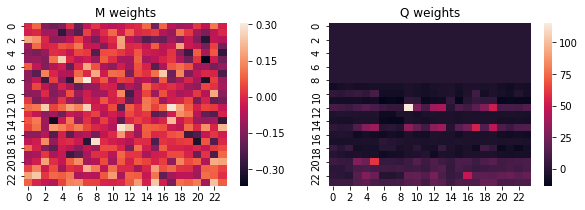

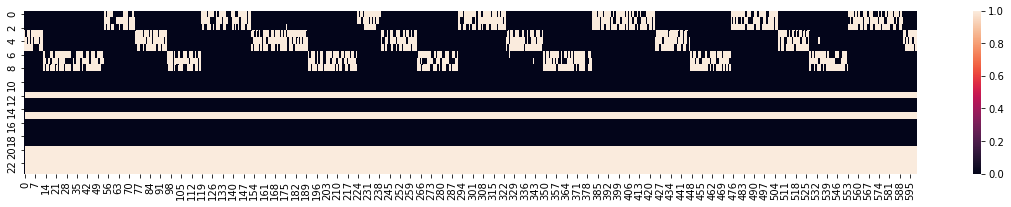

iter: 85, M: -1216729.89492, Q: -6.00065655299


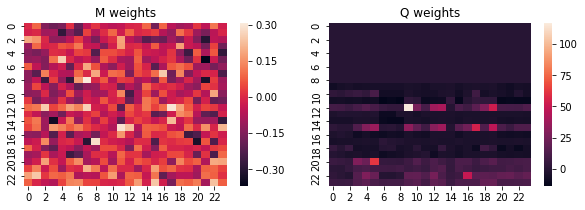

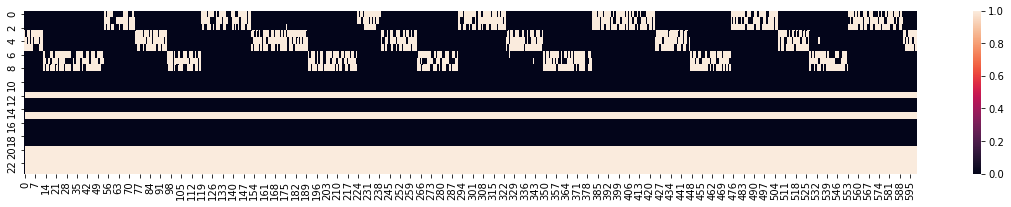

iter: 86, M: -1211962.86859, Q: -6.00065689686


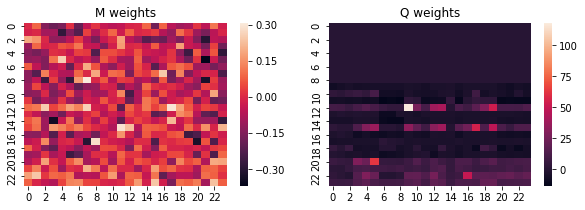

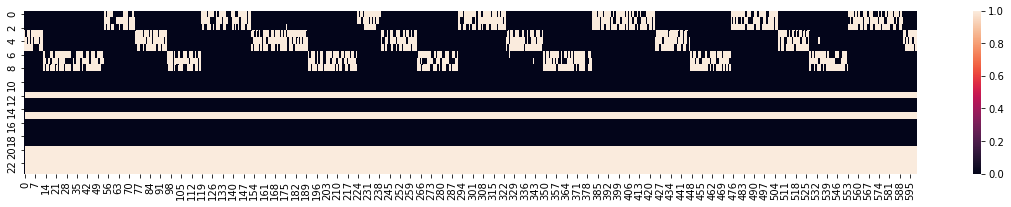

iter: 87, M: -1207231.36044, Q: -6.00065730013


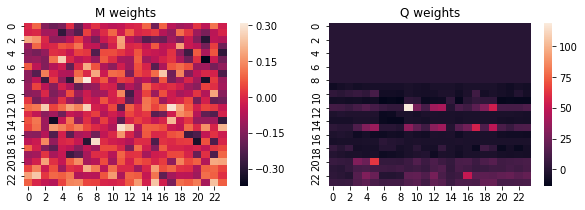

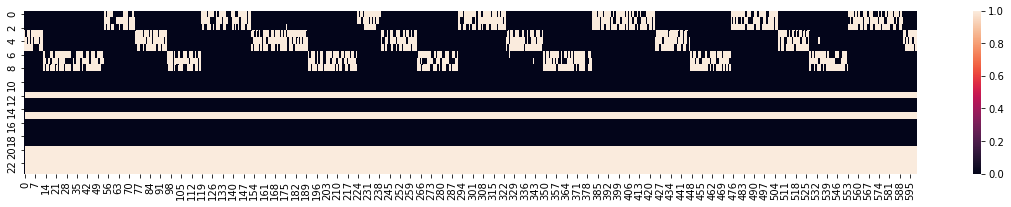

iter: 88, M: -1202535.08152, Q: -6.0006577575


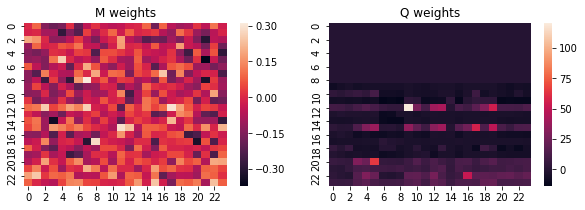

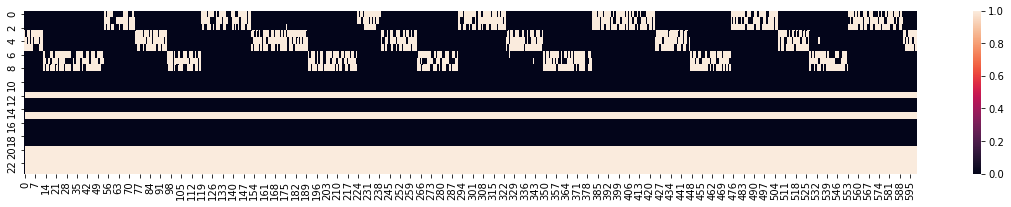

iter: 89, M: -1197873.74508, Q: -6.0006582642


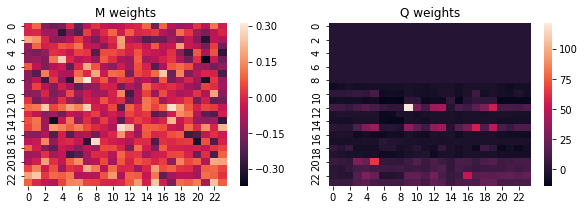

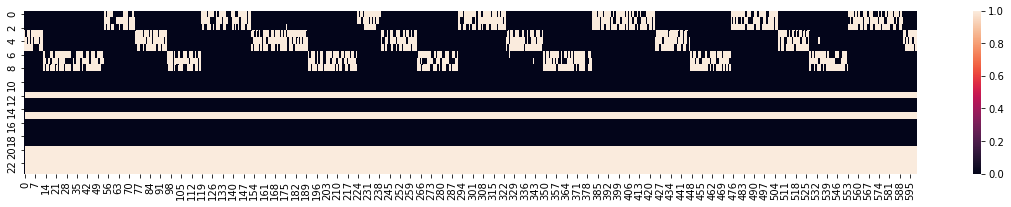

iter: 90, M: -1193247.06665, Q: -6.0006588159


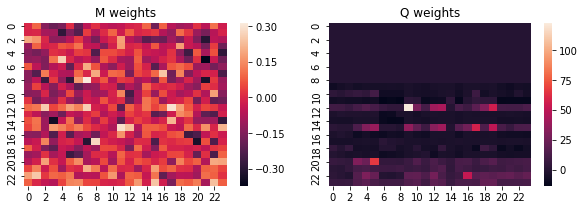

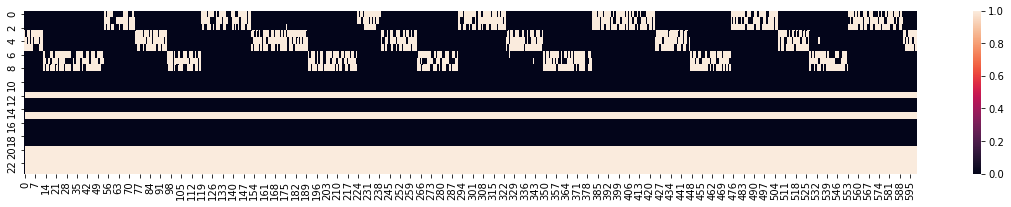

iter: 91, M: -1188654.76391, Q: -6.0006594087


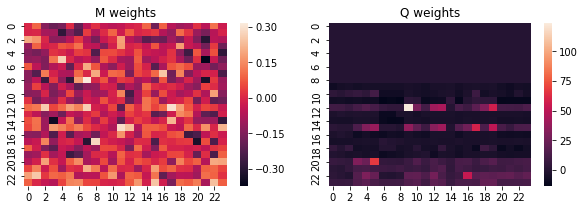

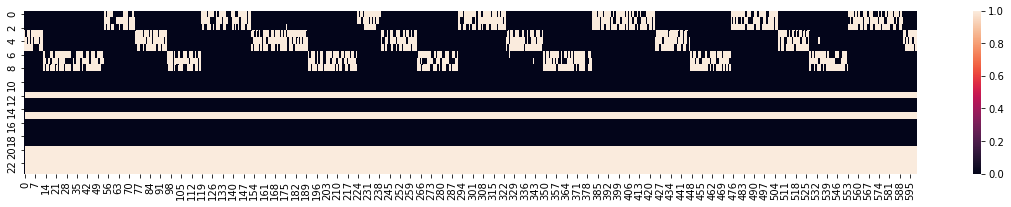

iter: 92, M: -1184096.55682, Q: -6.00066003906


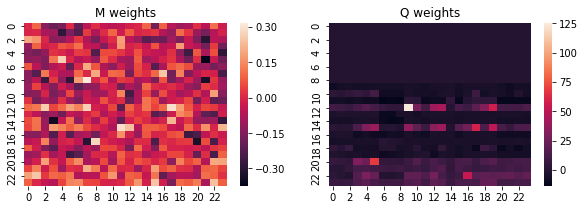

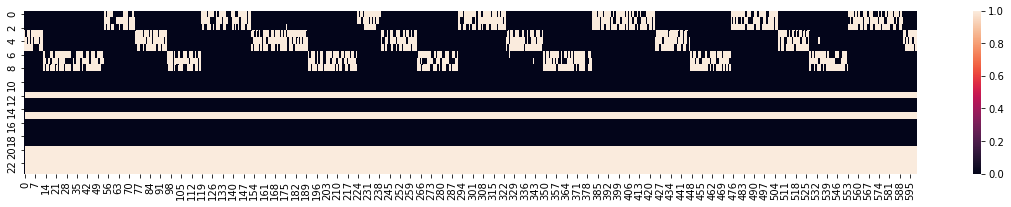

iter: 93, M: -1179572.1675, Q: -6.00066070379


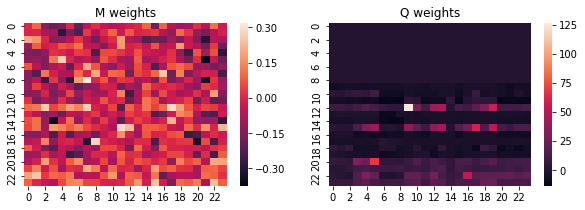

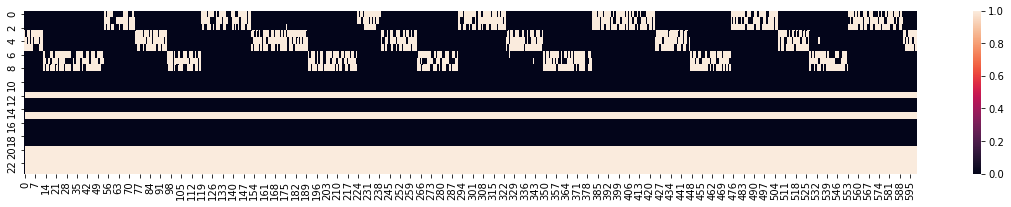

KeyboardInterrupt: 

In [57]:
## TRAINING
num_timebins = 100000
num_total_timebins = 100000
print_iter = 1

# LEARNING PARAMETERS
num_iters = 100000
variance_reduction_window = 5 # window of past free energies to average and subtract (reduces gradient variance)

# initialize Adam paramters
alpha = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8
m_M = np.zeros((num_neurons, num_neurons))
m_Q = np.zeros((num_neurons, num_neurons))
v_M = np.zeros((num_neurons, num_neurons))
v_Q = np.zeros((num_neurons, num_neurons))


# get a sample from the staircase pattern
spikes, phi, eta, u, spike_probs = get_staircase(num_timebins, 
                                                  num_neurons_=num_neurons, 
                                                  num_visible_=num_visible, 
                                                  weight_matrix=learned_weights_M,
                                                  stair_fr=stair_firing_rate, 
                                                  nonstair_fr=nonstair_firing_rate)


for iter_num in range(num_iters):
    
    spikes_Q, spike_probs_Q, u_Q, eta_Q, phi_Q = simulate_q_network(num_timebins)
    

    # Set hidden neuron activity to be those just simulated from Q network
    spikes[num_visible:, :] = spikes_Q[num_visible:, :].copy()
    phi[num_visible:, :] = phi_Q[num_visible:, :].copy()
    eta[num_visible:, :] = eta_Q[num_visible:, :].copy()
    u[num_visible:, :] = u_Q[num_visible:, :].copy()
    spike_probs[num_visible:, :] = spike_probs_Q[num_visible:, :].copy()
    
    # M likelihood
    curr_LL_M = LL_M(learned_weights_M)
    LL_M_trace.append(curr_LL_M)
    
    # Q likelihood
    curr_LL_Q = LL_Q(learned_weights_Q)
    LL_Q_trace.append(curr_LL_Q)
    
    # Calculate point estimate of free energy
    free_energy = curr_LL_Q - curr_LL_M
    free_energy_trace.append(free_energy)
    
    # M gradient
#     M_weights_gradients = grad_LL_M(learned_weights_M)
    M_weights_gradients = LL_M_gradient_by_hand(learned_weights_M, phi, eta, spikes)
    
    # adam updates
    m_M = beta_1 * m_M + (1 - beta_1) * M_weights_gradients
    v_M = beta_2 * v_M + (1 - beta_2) * np.power(M_weights_gradients, 2)
    m_hat_M = m_M / (1 - beta_1**(iter_num + 1))
    v_hat_M = v_M / (1 - beta_2**(iter_num + 1))
    
    # update M weights
    learned_weights_M = learned_weights_M + alpha * m_hat_M / (np.sqrt(v_hat_M + epsilon))
    np.fill_diagonal(learned_weights_M[:num_visible, :num_visible], 0)
    
    # Q gradient
#     Q_weights_gradients = grad_LL_Q(learned_weights_Q)
    Q_weights_gradients = LL_Q_gradient_by_hand(learned_weights_Q, phi_Q, eta_Q, spikes_Q)

    # Variance reduction technique from paper (mean-subtract free energy)
    if iter_num == 0:
        curr_free_energy = free_energy / 1000
    else:
        curr_window_start_idx = max(-variance_reduction_window, -len(free_energy_trace))
        curr_free_energy = free_energy - np.mean(free_energy_trace[curr_window_start_idx:])
        mean_subtract_free_energy_trace.append(curr_free_energy)
        
    # adam updates
    m_Q = beta_1 * m_Q + (1 - beta_1) * (Q_weights_gradients * free_energy / 1000)
    v_Q = beta_2 * v_Q + (1 - beta_2) * np.power(Q_weights_gradients, 2)
    m_hat_Q = m_Q / (1 - beta_1**(iter_num + 1))
    v_hat_Q = v_Q / (1 - beta_2**(iter_num + 1))
    
    # update M weights
    learned_weights_Q = learned_weights_Q - alpha * m_hat_Q / (np.sqrt(v_hat_Q + epsilon))

    # update Q weights
#     learned_weights_Q -= mu_Q * Q_weights_gradients * free_energy

    # reset connections to visible to 0
    learned_weights_Q[:num_visible, :] = 0
    
    # print progress
    if iter_num % print_iter == 0:
        print 'iter: {}, M: {}, Q: {}'.format(iter_num, curr_LL_M, curr_LL_Q)
        
        ## HEATMAP LEARNED WEIGHTS
        heatmap_weights(learned_weights_M, learned_weights_Q)
        
        fig, ax = plt.subplots(figsize=(20, 3))
        sns.heatmap(spikes_Q[:, :600])
        plt.show()



In [ ]:
fig, ax1 = plt.subplots(figsize = (8, 5))
plt.plot(mean_subtract_free_energy_trace, label="F - $F_{avg}$")
plt.plot(free_energy_trace, label = "F")
plt.legend()
plt.xlabel("Training epoch")
plt.ylabel("Free energy")
plt.show()

In [ ]:
## PLOT LOSS OVER TIME
fig, ax1 = plt.subplots(figsize = (10, 5))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('M -LL', color=color)
ax1.plot(LL_M_trace, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Q -LL', color=color)  # we already handled the x-label with ax1
ax2.plot(LL_Q_trace, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
## HEATMAP LEARNED WEIGHTS
heatmap_weights(learned_weights_M, learned_weights_Q)

In [ ]:
## SIMULATE LEARNED M NETWORK


num_simulated_timebins = 1000
phi_sim = np.zeros(shape=(num_neurons, num_simulated_timebins))
eta_sim = np.zeros(shape =(num_neurons, num_simulated_timebins))
u_sim = np.zeros(shape =(num_neurons, num_simulated_timebins))
spikes_sim = np.zeros(shape =(num_neurons, num_simulated_timebins))
spike_probs_sim = np.zeros(shape=(num_neurons, num_simulated_timebins))

# heat up network with a staircase before simulating
spikes, phi, eta, u, spike_probs = get_staircase(200, 
                                                      num_neurons_=num_neurons, 
                                                      num_visible_=num_visible, 
                                                      weight_matrix=learned_weights_M,
                                                      stair_fr=stair_firing_rate, 
                                                      nonstair_fr=nonstair_firing_rate)

phi_sim[:, :200] = phi.copy()
eta_sim[:, :200] = eta.copy()
spikes_sim[:, :200] = spikes.copy()
u_sim[:, :200] = u.copy()

for tt in range(1, 1000):

    dphi = get_phi_or_eta_update(data=spikes_sim, phi_or_eta=phi_sim, curr_time=tt, time_constant=tau, timescale=dt)
    deta = get_phi_or_eta_update(data=spikes_sim, phi_or_eta=eta_sim, curr_time=tt, time_constant=tau_adapt, timescale=dt)

    phi_sim[:, tt] = phi_sim[:, tt - 1] + dphi
    eta_sim[:, tt] = eta_sim[:, tt - 1] + deta

    total_potential = np.matmul(learned_weights_M, phi_sim[:, tt]) - eta_0 * eta_sim[:, tt]
    u_sim[:, tt] = total_potential 

    spike_probs_sim[:, tt] = sigmoid(u_sim[:, tt])

    # during "heat up" period, only simulate hidden neuron spikes
    if tt <= 90:
        spikes_sim[num_visible:, tt] = np.random.binomial(n = 1, p = spike_probs_sim[num_visible:, tt])
    else:
        spikes_sim[:, tt] = np.random.binomial(n = 1, p = spike_probs_sim[:, tt])

In [ ]:
## HEATMAP SIMULATED M NETWORK

fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes_sim[:, :600])
plt.ylabel("Neuron")
plt.title("Spikes")
plt.savefig("./plots/m_network_simulated_spikes.png", bbox_inches='tight')
plt.show()

In [ ]:
# Simulate Q network (inference mode)
spikes_sim_Q, phi_sim_Q, eta_sim_Q, u_sim_Q, spike_probs_sim_Q = get_staircase(num_timebins=1000, 
                                                      num_neurons_=num_neurons, 
                                                      num_visible_=num_visible, 
                                                      weight_matrix=learned_weights_Q,
                                                      stair_fr=stair_firing_rate, 
                                                      nonstair_fr=nonstair_firing_rate)

In [ ]:
## HEATMAP SIMULATED Q NETWORK
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes_sim_Q[:, :600])
plt.ylabel("Neuron")
plt.title("Spikes")
plt.show()